In [ ]:
## imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from datetime import date



In [ ]:
## Data collection of S&P 500

fromdate = datetime.datetime(2013, 2, 8)
todate = datetime.datetime(2018, 2, 7)
prices_master = pd.read_csv('all_stocks_5yr.csv',  parse_dates=True)

## Comapny and sector data
from pandas import DataFrame
companies = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies', flavor='bs4')
companies_sec = companies[0][['Symbol','GICS Sector']]
companies_sec_grp = companies_sec.groupby('GICS Sector')['Symbol']
companies_sec = list(set(companies_sec['GICS Sector']))
print(companies_sec)


##  Stock data of each sector from 2013 - 2018
sector_stock_data = {}
for sector in companies_sec:
  tickers = dict.fromkeys(companies_sec_grp.get_group(sector),[])
  if sector not in sector_stock_data:
    sector_stock_data[sector] = tickers
  for ticker in tickers:
    stock_data = prices_master[prices_master['Name'] == ticker][['date','open','high','low','close','volume']]
    sector_stock_data[sector][ticker] = DataFrame(stock_data)
    print("ticker_saved: ",ticker)

##  Stock data of each sector from 2013 - 2018
sector_wise_stockData = {}
sector_ticker = {} 
for sector in companies_sec:
  tickers = dict.fromkeys(companies_sec_grp.get_group(sector),[])
  if sector not in sector_ticker:
    sector_ticker[sector] = tickers
  stock_data_sector = pd.DataFrame()
  for ticker in tickers:
    stock_data = prices_master[prices_master['Name'] == ticker][['Name','date','open','high','low','close','volume']]
    data = [stock_data_sector, DataFrame(stock_data)]
    stock_data_sector = pd.concat(data)
  sector_wise_stockData[sector] = stock_data_sector

from google.colab import files
sector_stock_data = DataFrame(sector_stock_data).to_csv('sector_wise_stockData.csv')
files.download('sector_wise_stockData.csv')


In [46]:
'''
  Input : Cointegrated pairs and their p values
  Ouptut : Heatmap for visualizing 
'''
def heat_map(data):
  fig, ax = plt.subplots(figsize=(20,10))
  sns.heatmap(data, xticklabels = train_close.columns,yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",mask =  pvalues <= 0.90)
  ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
  plt.tight_layout()
  plt.show()


In [8]:
'''
  Input : Cointegrated pairs, trained model
  Output : Spread and augmented Dickey-Fuller test results
'''
def pair_test(pair_ticker,train_close):
  # final pair to test strategy
  asset1 = pair_ticker[0]
  asset2 = pair_ticker[1]

  # create a train dataframe of 2 assets
  train = pd.DataFrame()
  train['asset1'] = train_close[asset1]
  train['asset2'] = train_close[asset2]

  # visualize closing prices
  # ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
  # ax.set_ylabel("Closing Price")
  # ax.grid(True);
  # plt.show()

  # run OLS regression
  model=sm.OLS(train.asset2, train.asset1).fit()

  # # print regression summary results
  plt.rc('figure', figsize=(12, 7))
  plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
  plt.axis('off')
  plt.tight_layout()
  plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
  plt.show()
  print('Hedge Ratio = ', model.params[0])

  # calculate spread
  spread = train.asset2 - model.params[0] * train.asset1

  # # Plot the spread
  ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
  ax.set_ylabel("Spread")
  ax.grid(True);

  # conduct Augmented Dickey-Fuller test
  adf = adfuller(spread, maxlag = 1)
  print('Critical Value = ', adf[0])

  # probablity critical values
  print(adf[4])



In [50]:
# calculate z-score
def zscore(series):
 return (series - series.mean()) / np.std(series)

'''
  Input : Cointegrated pairs, trained model
  Output : Z-score, trading signals and calculatd portfolio
'''
def trading_signals(pair, test_close):
  # create a dataframe for trading signals
  signals = pd.DataFrame()
  asset1, asset2 = pair[0], pair[1]
  signals['asset1'] = test_close[asset1] 
  signals['asset2'] = test_close[asset2]
  ratios = signals.asset1 / signals.asset2

  # calculate z-score and define upper and lower thresholds
  signals['z'] = zscore(ratios)
  signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
  signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

  # create signal - short if z-score is greater than upper limit else long
  signals['signals1'] = 0
  signals['signals1'] = np.select([signals['z'] > \
                                  signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

  # we take the first order difference to obtain portfolio position in that stock
  signals['positions1'] = signals['signals1'].diff()
  signals['signals2'] = -signals['signals1']
  signals['positions2'] = signals['signals2'].diff()

  # verify datafame head and tail
  signals.head(3).append(signals.tail(3))

  # # visualize trading signals and position
  fig=plt.figure(figsize=(14,6))
  bx = fig.add_subplot(111)   
  bx2 = bx.twinx()

  #plot two different assets
  l1, = bx.plot(signals['asset1'], c='#4abdac')
  l2, = bx2.plot(signals['asset2'], c='#907163')
  u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
  d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
  u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
  d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
  bx.set_ylabel(asset1,)
  bx2.set_ylabel(asset2, rotation=270)
  bx.yaxis.labelpad=15
  bx2.yaxis.labelpad=15
  bx.set_xlabel('Date')
  bx.xaxis.labelpad=15
  plt.legend([l1,l2,u1,d1,u2,d2], [pair[0], pair[1],'LONG {}'.format(asset1),
            'SHORT {}'.format(asset1),
            'LONG {}'.format(asset2),
            'SHORT {}'.format(asset2)], loc ='best')
  plt.title('Pair Trading')
  plt.xlabel('Date')
  plt.grid(True)
  plt.show()


  # initial capital to calculate the actual pnl
  initial_capital = 100000

  # shares to buy for each position
  positions1 = initial_capital// max(signals['asset1'])
  positions2 = initial_capital// max(signals['asset2'])

  # since there are two assets, we calculate each asset Pnl 
  # separately and in the end we aggregate them into one portfolio
  portfolio = pd.DataFrame()
  portfolio['asset1'] = signals['asset1']
  portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
  portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
  portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
  portfolio['return1'] = portfolio['total asset1'].pct_change()
  portfolio['positions1'] = signals['positions1']

  # pnl for the 2nd asset
  portfolio['asset2'] = signals['asset2']
  portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
  portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
  portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
  portfolio['return2'] = portfolio['total asset2'].pct_change()
  portfolio['positions2'] = signals['positions2']

  # total pnl and z-score
  portfolio['z'] = signals['z']
  portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
  portfolio['z upper limit'] = signals['z upper limit']
  portfolio['z lower limit'] = signals['z lower limit']
  portfolio = portfolio.dropna()

  # plot the asset value change of the portfolio and pnl along with z-score
  fig = plt.figure(figsize=(14,6),)
  ax = fig.add_subplot(111)
  ax2 = ax.twinx()
  l1, = ax.plot(portfolio['total asset'], c='g')
  l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
  b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                  portfolio['z lower limit'], \
                  alpha=0.2,color='#ffb48f')
  ax.set_ylabel('Asset Value')
  ax2.set_ylabel('Z Statistics',rotation=270)
  ax.yaxis.labelpad=15
  ax2.yaxis.labelpad=15
  ax.set_xlabel('Date')
  ax.xaxis.labelpad=15
  plt.title('Portfolio Performance with Profit and Loss')
  plt.legend([l2,b,l1],['Z Statistics',
                        'Z Statistics +-1 Sigma',
                        'Total Portfolio Value'],loc='upper left');
  plt.show()

  # calculate CAGR
  final_portfolio = portfolio['total asset'].iloc[-1]
  delta = (datetime.datetime.strptime(portfolio.index[-1], '%Y-%m-%d') - datetime.datetime.strptime(portfolio.index[0], '%Y-%m-%d')).days 
  # delta = (date(portfolio.index[-1]) - date(portfolio.index[0])).days
  # # print('Number of days = ', delta)
  YEAR_DAYS = 365
  returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
  # print('Compounded Annual Rate of Growth = {:.3f}%' .format(returns * 100))
  return returns




In [ ]:
## Get cointegrated pairs in each industry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split


def main(stocks):
  close = stocks.unstack(['Name'])['close'].sort_index()
  close = close.dropna()
  close.head(2)

  # train test split 
  train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

  # quick view of head and tail of train set
  train_close.head(2).append(train_close.tail(2))

  # Pearson correlation to get the basic idea about the relationship
  # fig, ax = plt.subplots(figsize=(25,25))
  # sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
  # ax.set_title('Assets Correlation Matrix')
  # plt.show()

  # function to find cointegrated pairs
  def find_cointegrated_pairs(data):
      highly_correlated_pairs = []
      highly_correlated_pairs_p_value = {}
      n = data.shape[1]
      pvalue_matrix = np.ones((n, n))
      keys = data.keys()
      pairs = []
      for i in range(n):
          for j in range(i+1, n):
              result = coint(data[keys[i]], data[keys[j]])
              pvalue_matrix[i, j] = result[1]
              if result[1] < 0.05:
                  pairs.append((keys[i], keys[j]))
                  highly_correlated_pairs.append([keys[i], keys[j]])
                  highly_correlated_pairs_p_value[(keys[i], keys[j])] = result[1]
                  
      return pvalue_matrix, pairs,highly_correlated_pairs,highly_correlated_pairs_p_value


  pvalues, pairs,highly_correlated_pairs,highly_correlated_pairs_p_value  = find_cointegrated_pairs(train_close)

  # heat_map(pvalues)

  sorted_pairs = sorted(highly_correlated_pairs_p_value .items(), key=lambda kv: kv[1])
  top_pairs = sorted_pairs[:3]
  co_pairs = []
  
  for pair in top_pairs:
    co_pairs.append(pair[0])

  print("Co-Pairs",co_pairs)
  pd.DataFrame(co_pairs).to_csv("sec_wise_copaired.csv")
  
stock_data = pd.read_csv("/content/all_stocks_5yr.csv")
main()


In [ ]:
ssecWise_pairs_dict = {
    'Consumer Discretionary': [['SBUX', 'VFC'],['EBAY', 'LEN'],['EXPE', 'ULTA']],
    'Health Care': [['IQV', 'LLY'],['BDX', 'MDT'],['BDX', 'CVS']],
    'Communication Services':[['CMCSA', 'DIS'],['CMCSA', 'EA'],['CHTR', 'EA']],
    'Utilities': [['ES', 'WEC'],['DTE', 'EIX'],['CMS', 'XEL']],
    'Consumer Staples': [['EL', 'KO'],['CLX', 'WBA'],['K', 'SJM']],
    'Materials': [['FCX', 'MLM'],['FCX', 'VMC'],['FCX', 'SEE']],
    'Industrials': [['GD', 'PH'],['CAT', 'RHI'],['CAT', 'UAL']],
    'Financials': [['C', 'CMA'],['AMP', 'AXP'],['LNC', 'RF']],
    'Information Technology': [['FFIV', 'V'],['AVGO', 'CTSH'],['FFIV', 'STX']],
    'Energy': [['CVX', 'MRO'],['APA', 'OXY'],['HES', 'OKE']],
    'Real Estate': [['ARE', 'EQR'],['CCI', 'ESS'],['CCI', 'FRT']]
}
secWise_pairs_dict

In [68]:
secWise_pairs = [['SBUX', 'VFC'],['EBAY', 'LEN'],['EXPE', 'ULTA'],['IQV', 'LLY'],['BDX', 'MDT'],['BDX', 'CVS'],['CMCSA', 'DIS'],['CMCSA', 'EA'],['CHTR', 'EA'],['ES', 'WEC'],['DTE', 'EIX'],['CMS', 'XEL'],['EL', 'KO'],['CLX', 'WBA'],['K', 'SJM'],['FCX', 'MLM'],['FCX', 'VMC'],['FCX', 'SEE'],['GD', 'PH'],['CAT', 'RHI'],['CAT', 'UAL'],['C', 'CMA'],['AMP', 'AXP'],['LNC', 'RF'],['FFIV', 'V'],['AVGO', 'CTSH'],['FFIV', 'STX'],['CVX', 'MRO'],['APA', 'OXY'],['HES', 'OKE'],['ARE', 'EQR'],['CCI', 'ESS'],['CCI', 'FRT']]


------------------------------ ['SBUX', 'VFC'] ------------------------------ 



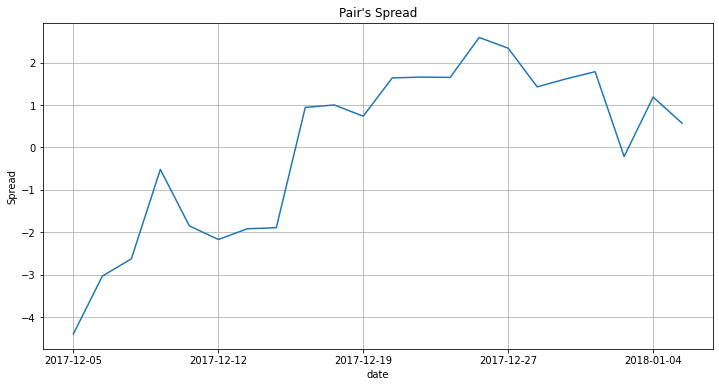

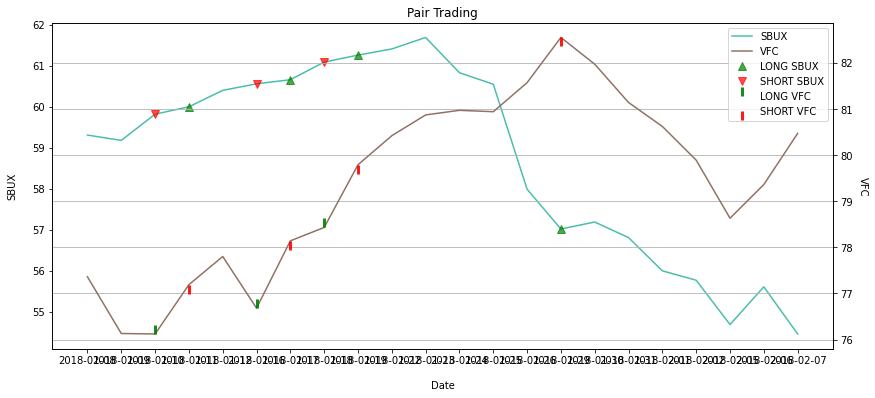

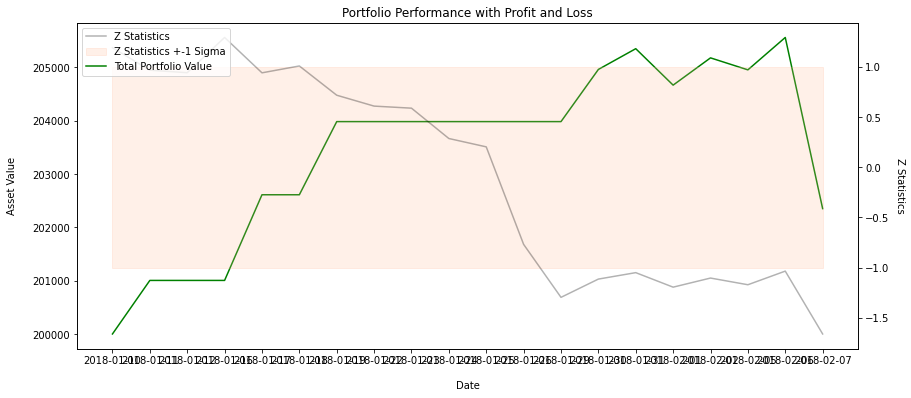

-------------------------------------------------------------------------------- 


------------------------------ ['EBAY', 'LEN'] ------------------------------ 



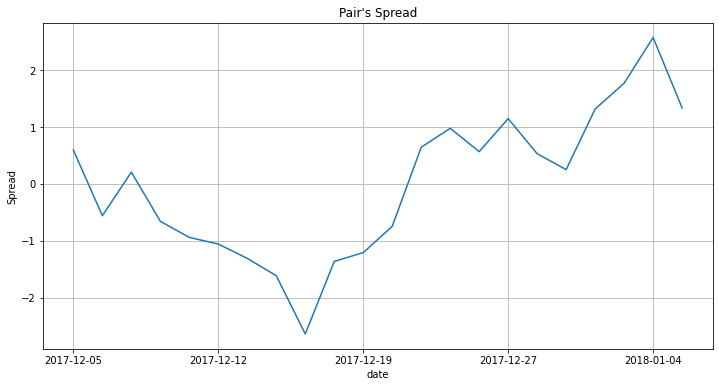

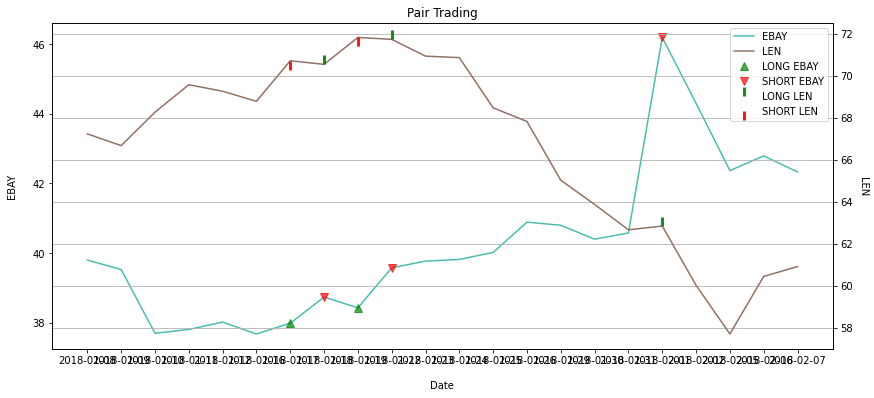

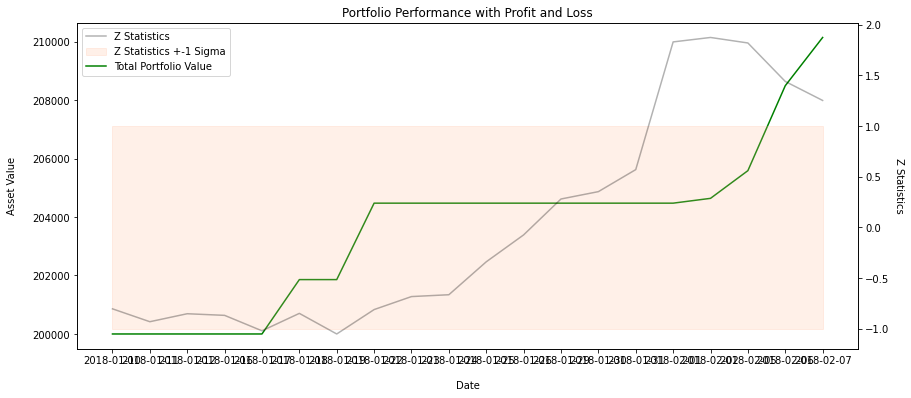

-------------------------------------------------------------------------------- 


------------------------------ ['EXPE', 'ULTA'] ------------------------------ 



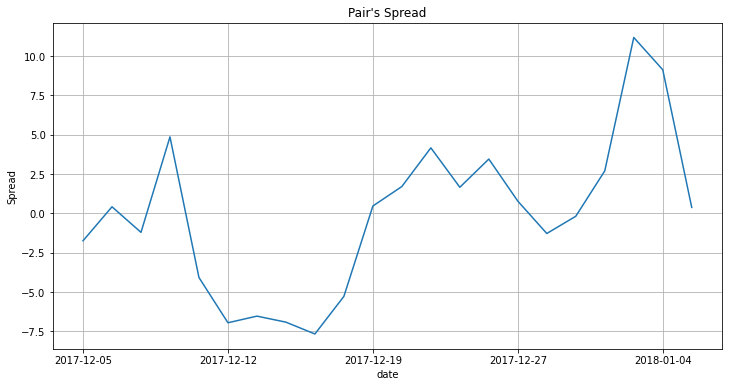

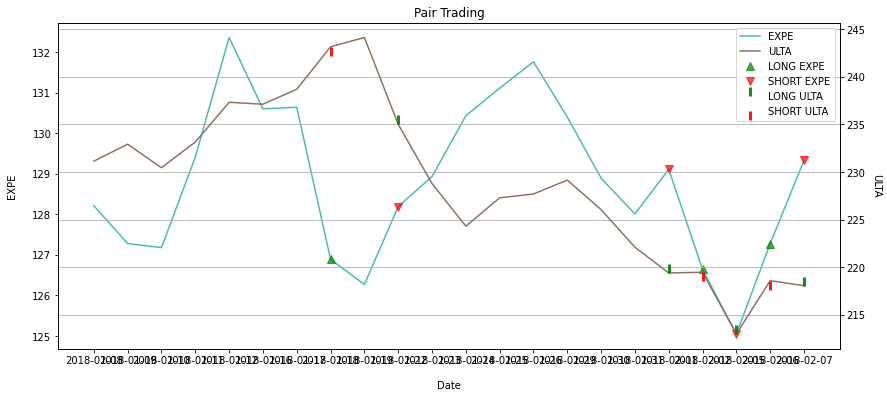

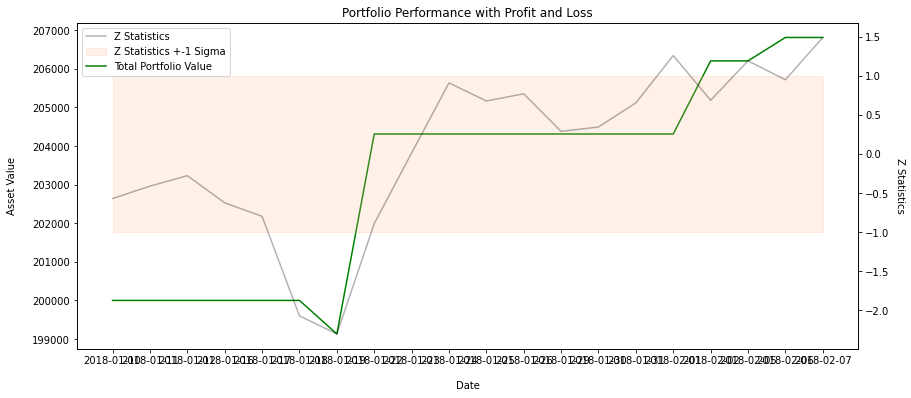

-------------------------------------------------------------------------------- 


------------------------------ ['IQV', 'LLY'] ------------------------------ 



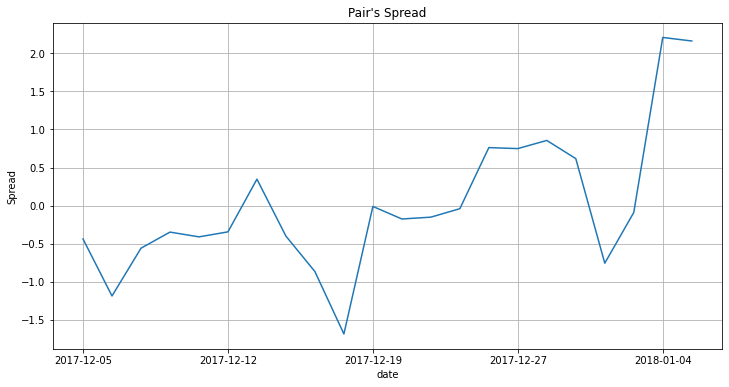

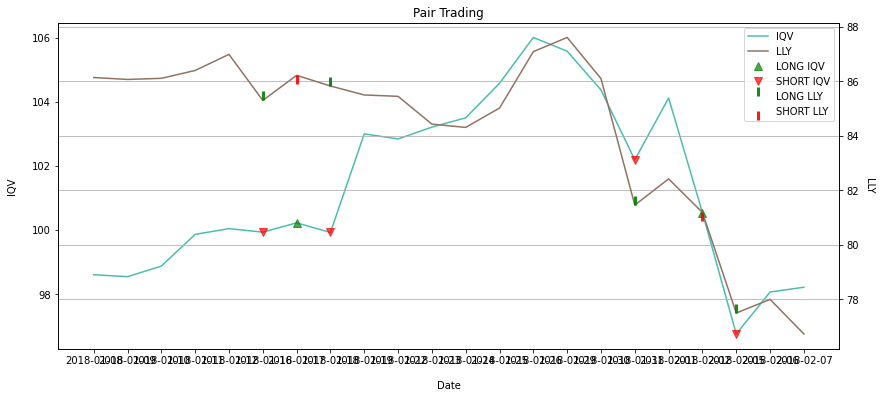

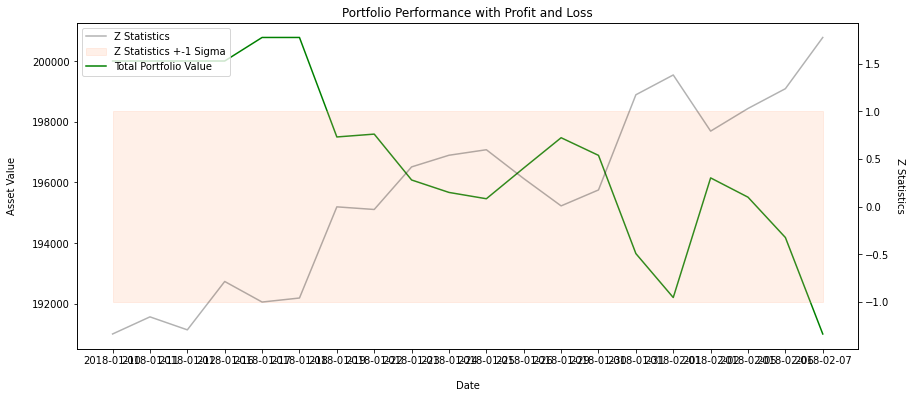

-------------------------------------------------------------------------------- 


------------------------------ ['BDX', 'MDT'] ------------------------------ 



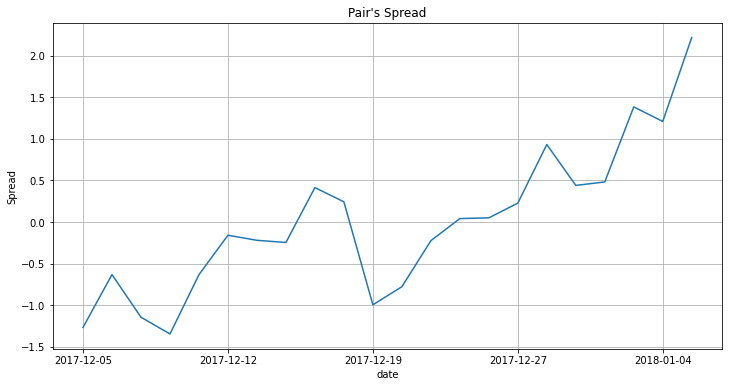

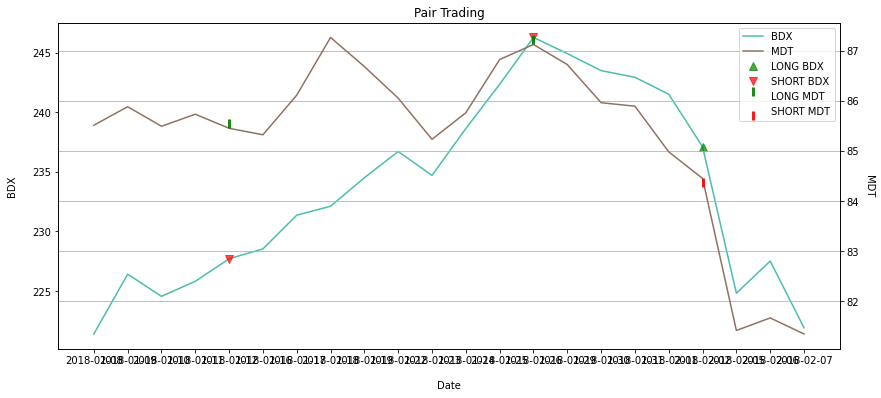

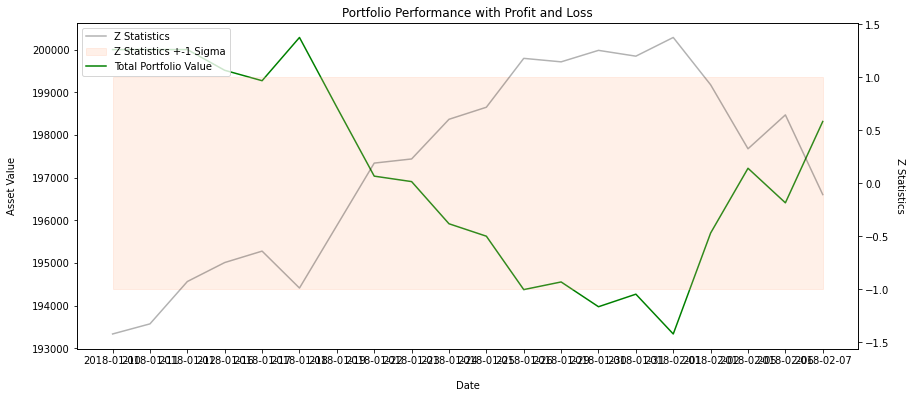

-------------------------------------------------------------------------------- 


------------------------------ ['BDX', 'CVS'] ------------------------------ 



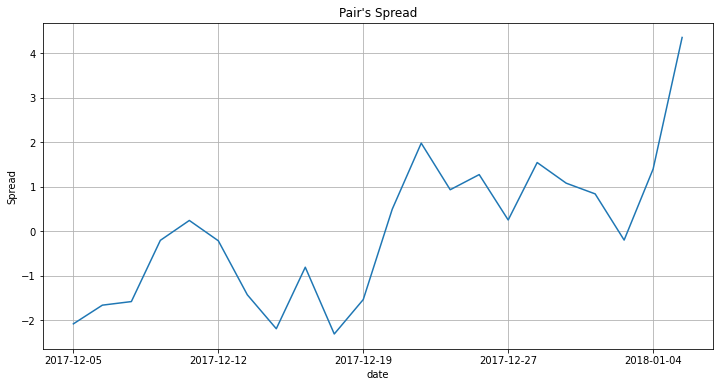

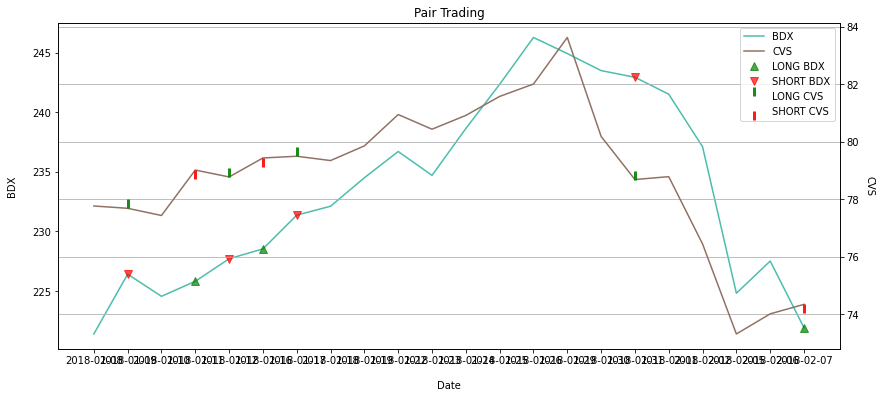

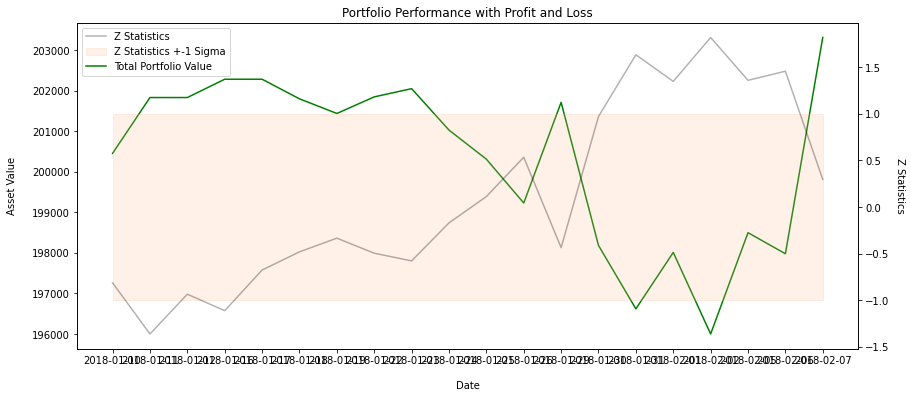

-------------------------------------------------------------------------------- 


------------------------------ ['CMCSA', 'DIS'] ------------------------------ 



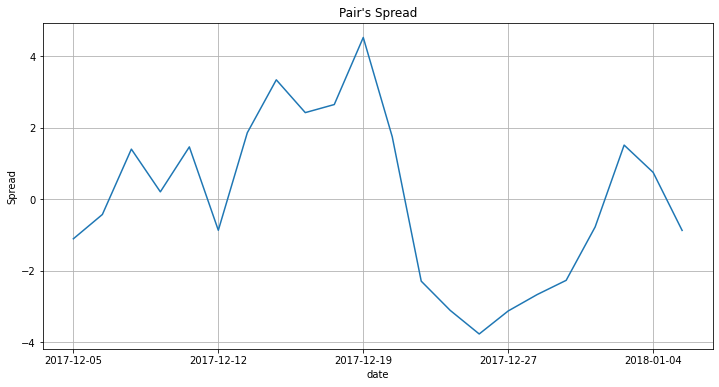

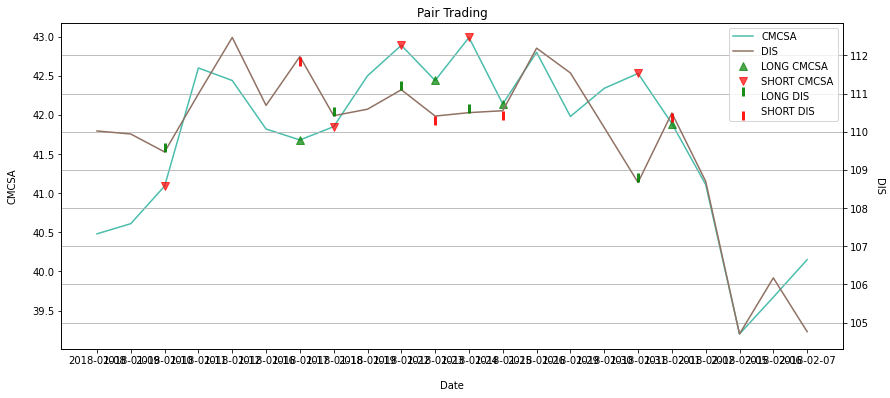

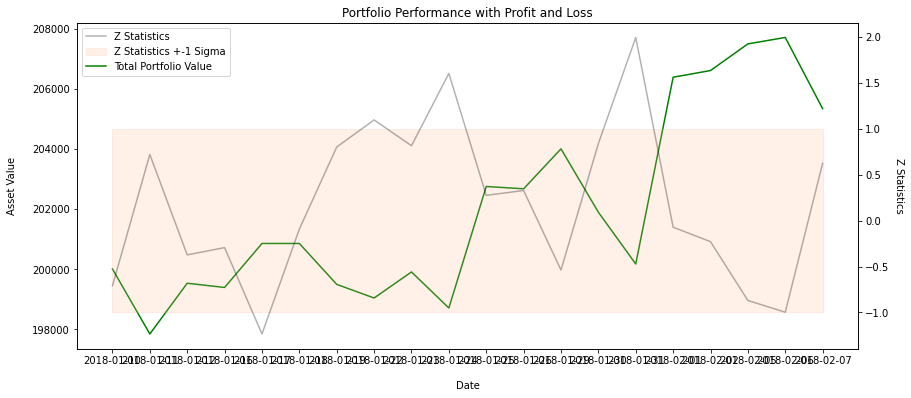

-------------------------------------------------------------------------------- 


------------------------------ ['CMCSA', 'EA'] ------------------------------ 



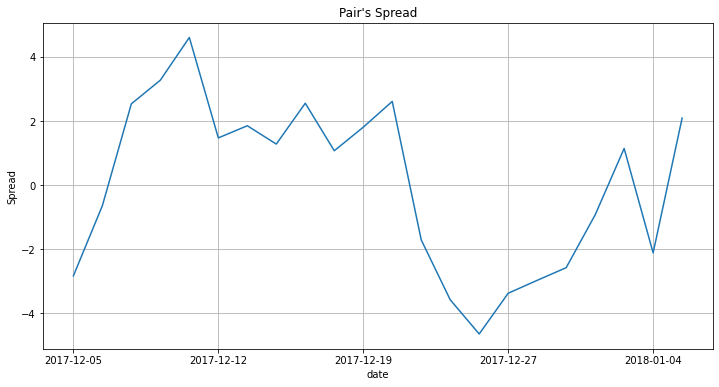

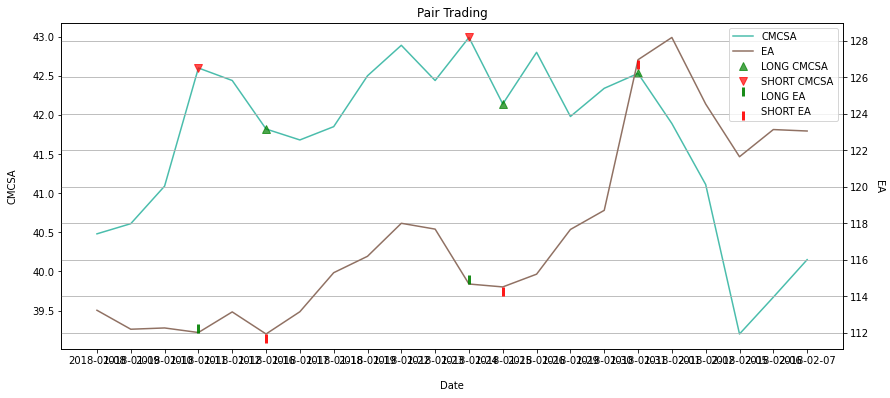

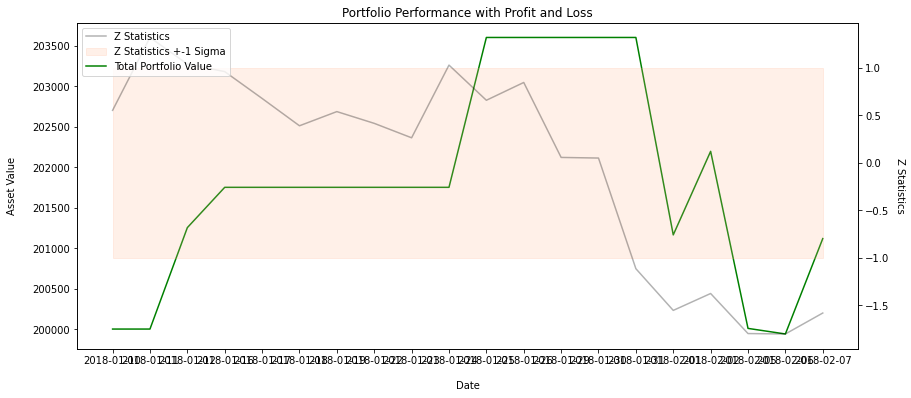

-------------------------------------------------------------------------------- 


------------------------------ ['CHTR', 'EA'] ------------------------------ 



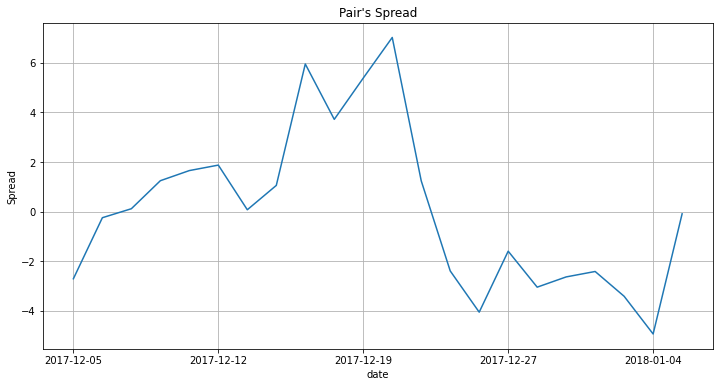

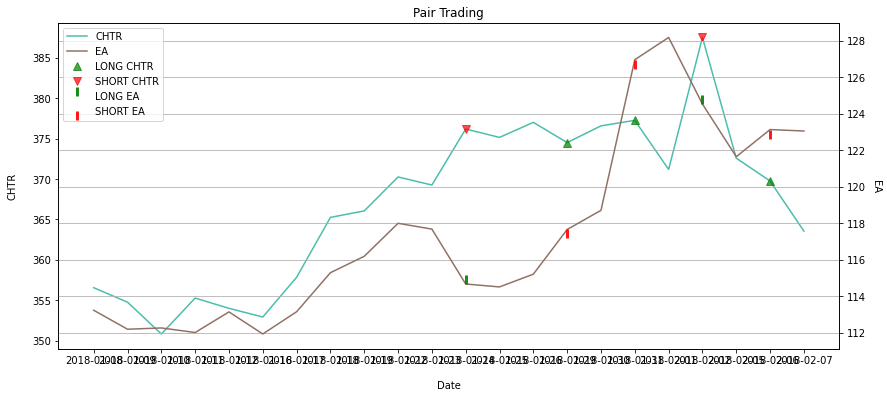

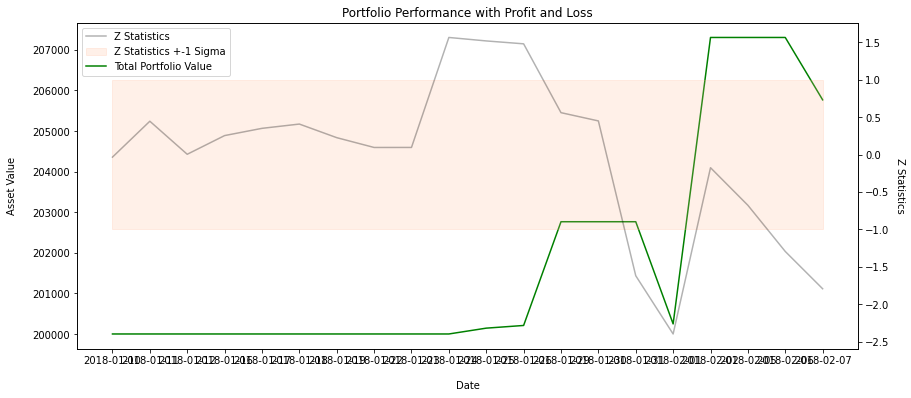

-------------------------------------------------------------------------------- 


------------------------------ ['ES', 'WEC'] ------------------------------ 



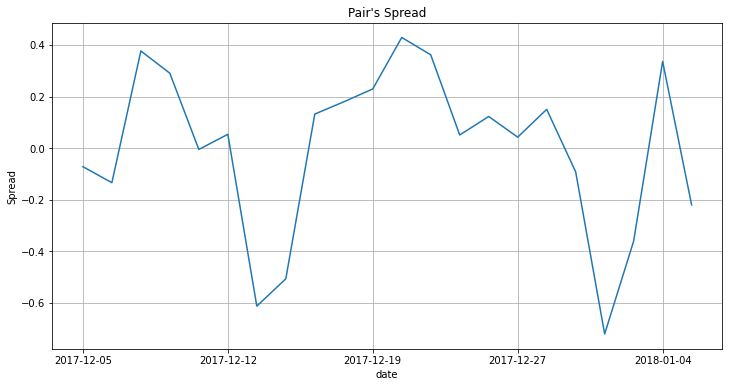

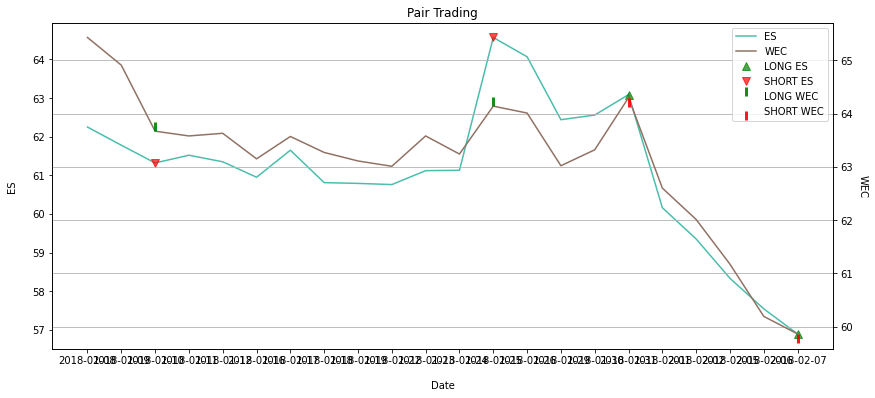

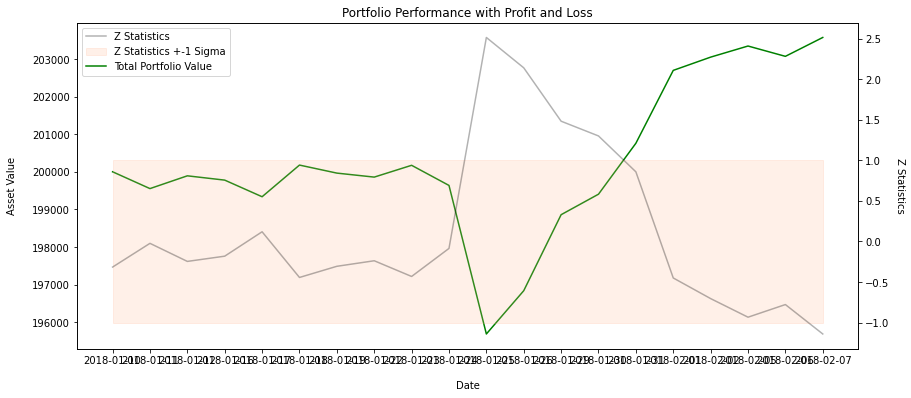

-------------------------------------------------------------------------------- 


------------------------------ ['DTE', 'EIX'] ------------------------------ 



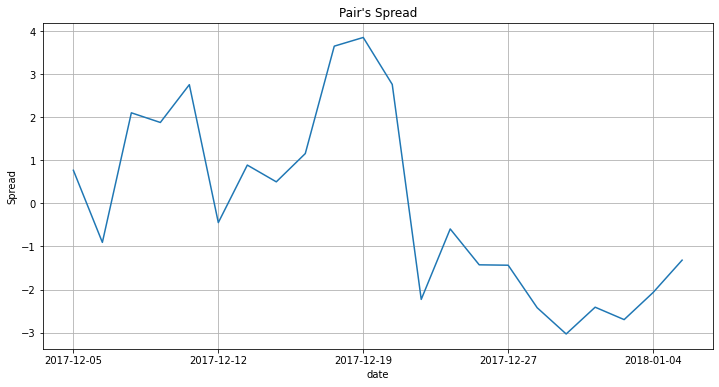

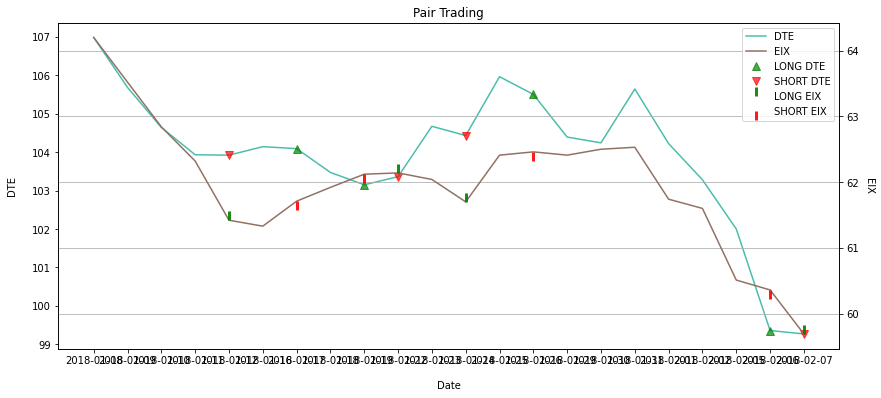

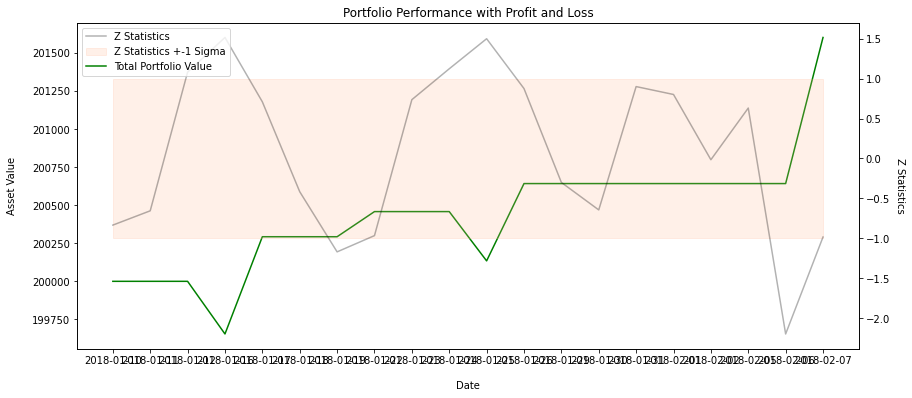

-------------------------------------------------------------------------------- 


------------------------------ ['CMS', 'XEL'] ------------------------------ 



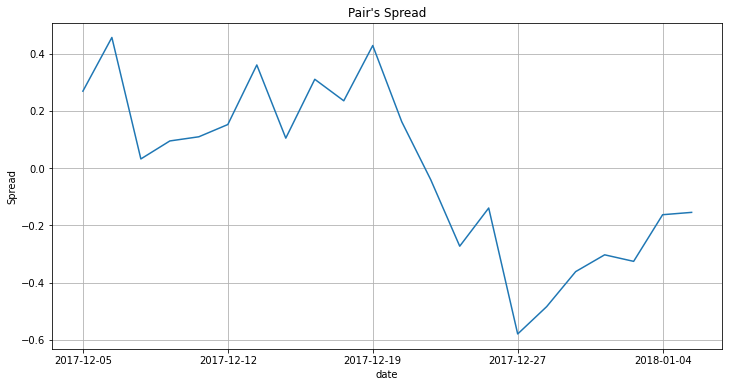

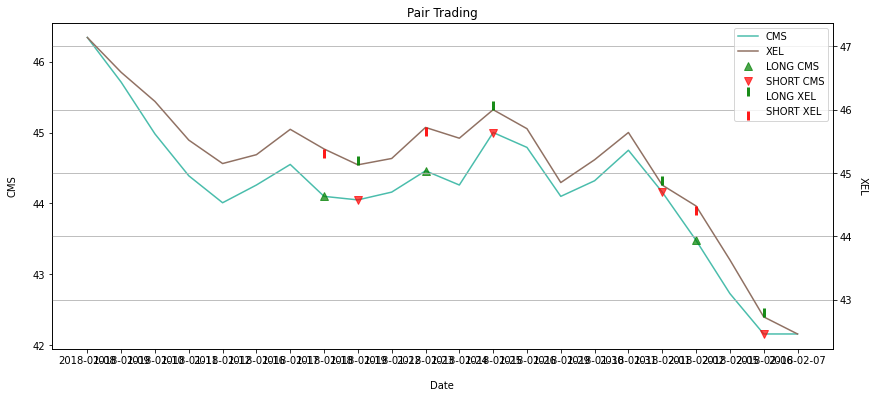

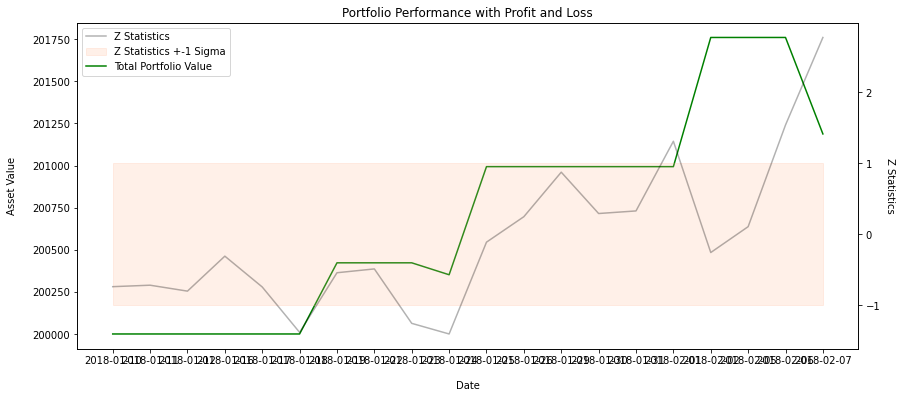

-------------------------------------------------------------------------------- 


------------------------------ ['EL', 'KO'] ------------------------------ 



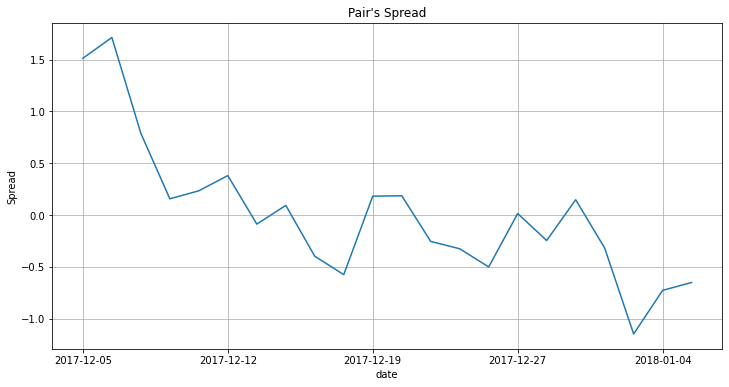

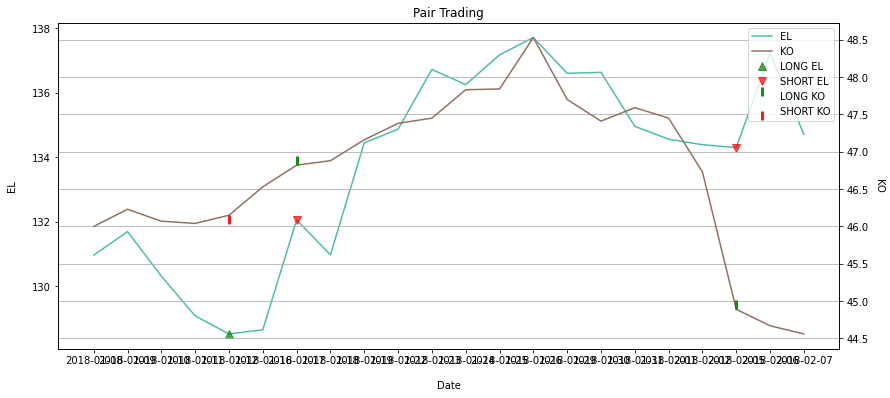

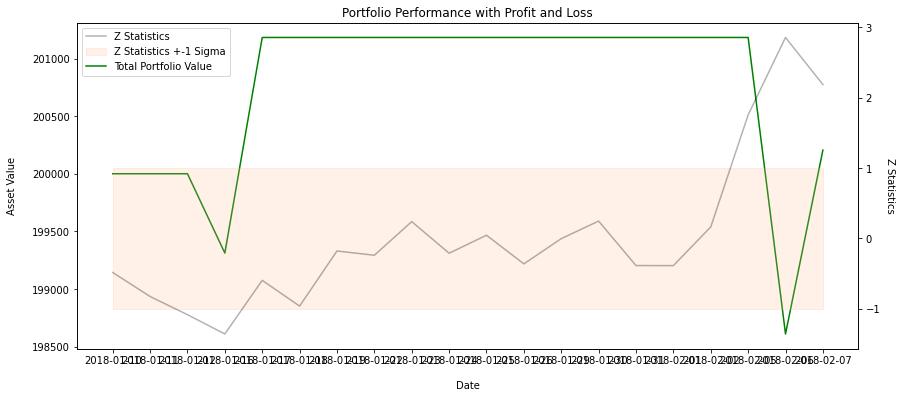

-------------------------------------------------------------------------------- 


------------------------------ ['CLX', 'WBA'] ------------------------------ 



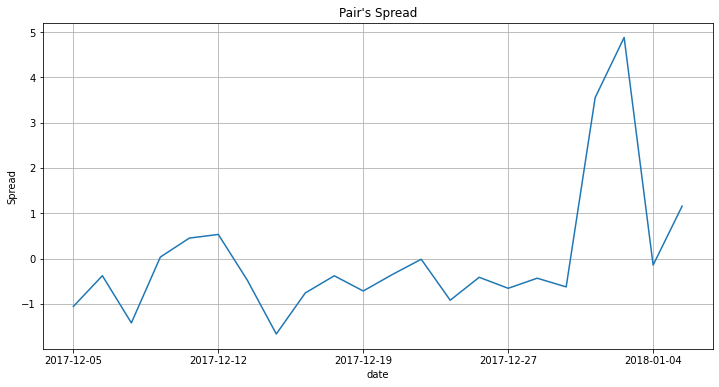

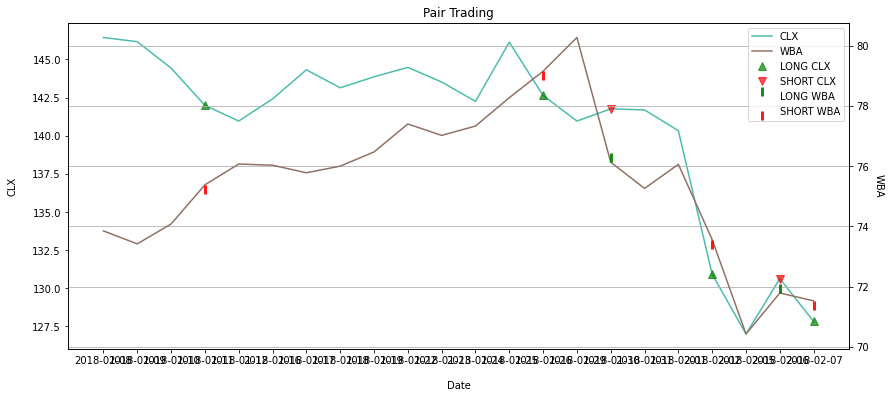

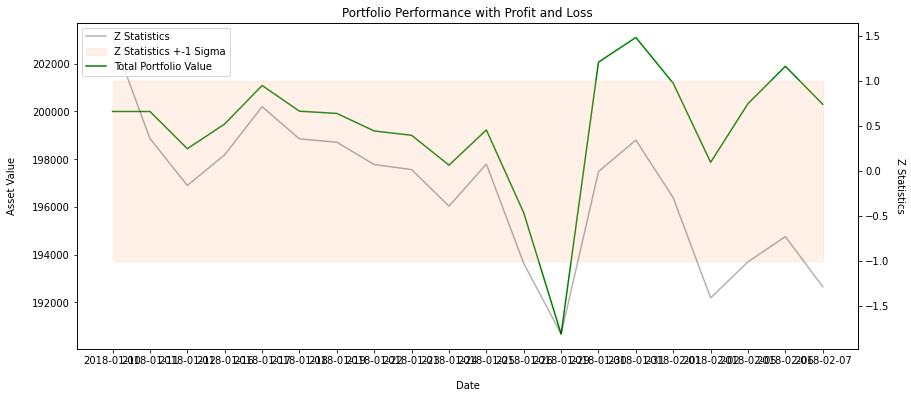

-------------------------------------------------------------------------------- 


------------------------------ ['K', 'SJM'] ------------------------------ 



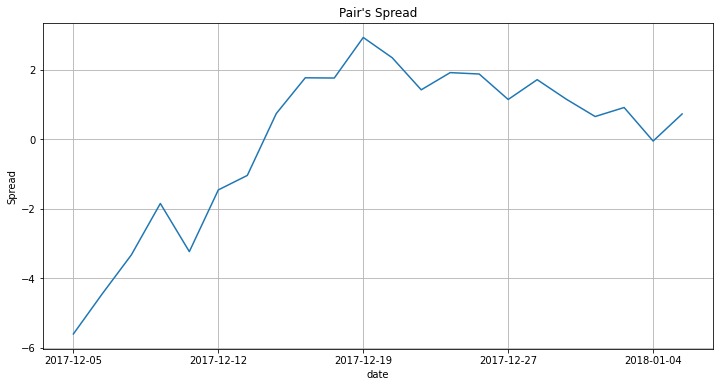

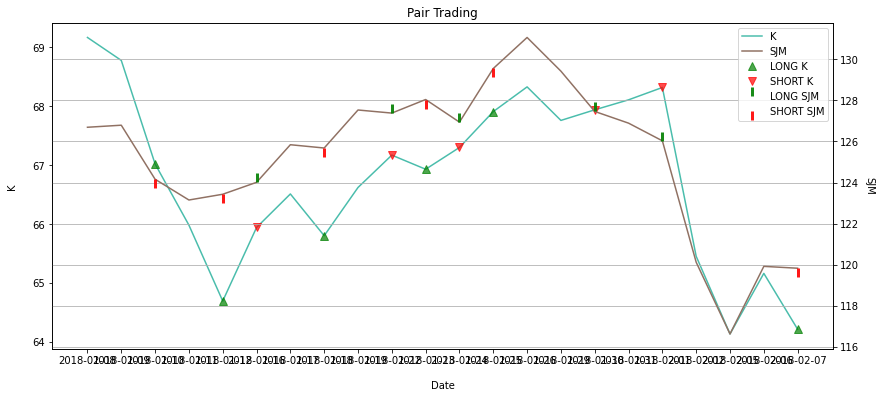

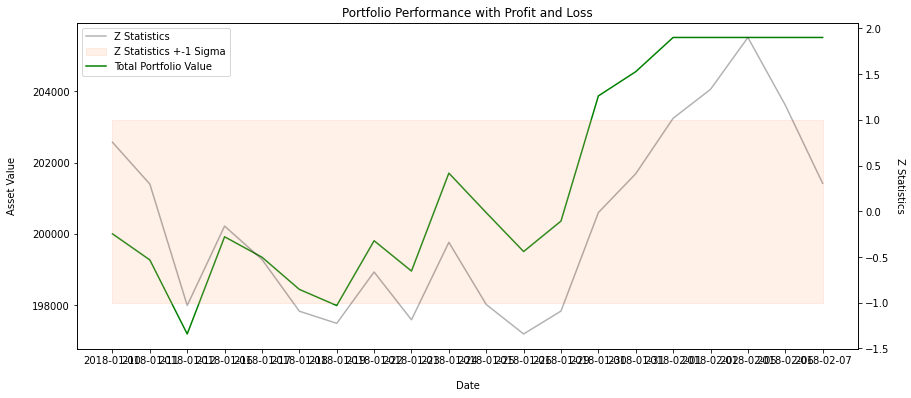

-------------------------------------------------------------------------------- 


------------------------------ ['FCX', 'MLM'] ------------------------------ 



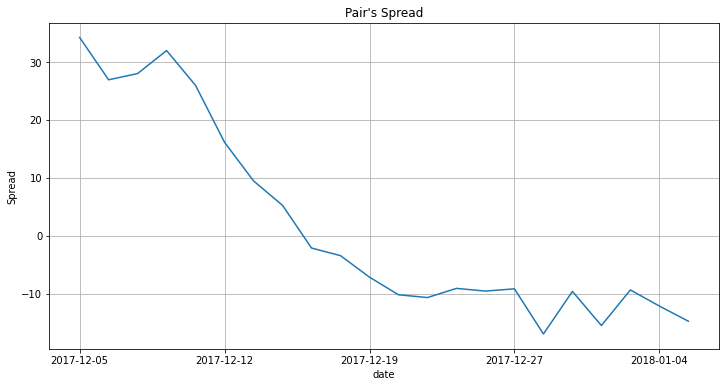

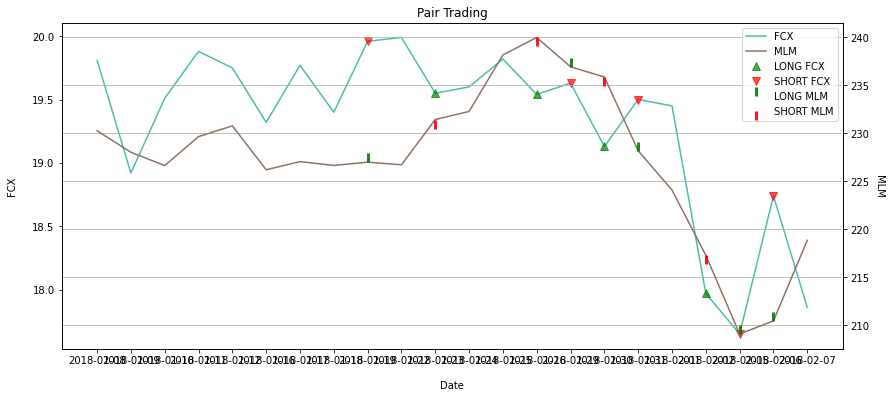

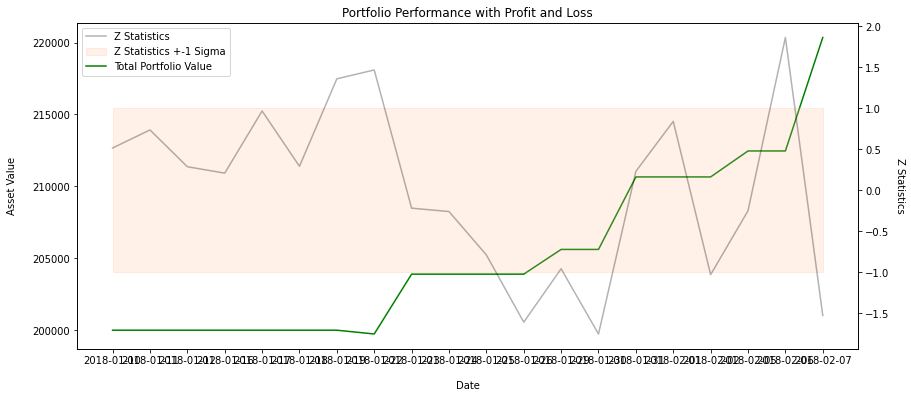

-------------------------------------------------------------------------------- 


------------------------------ ['FCX', 'VMC'] ------------------------------ 



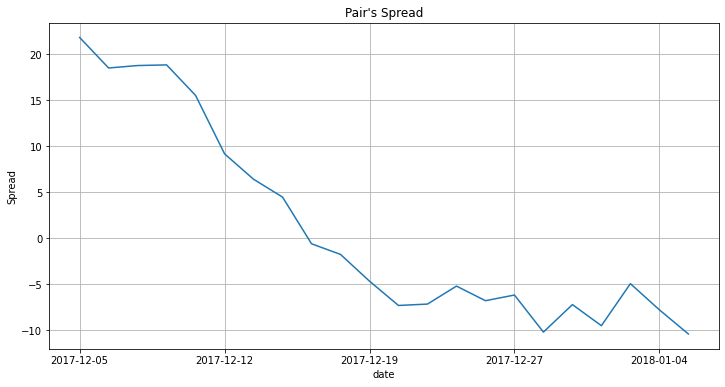

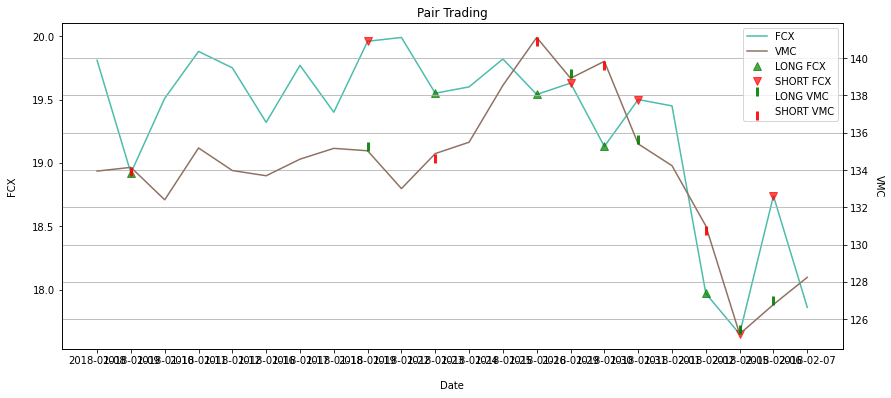

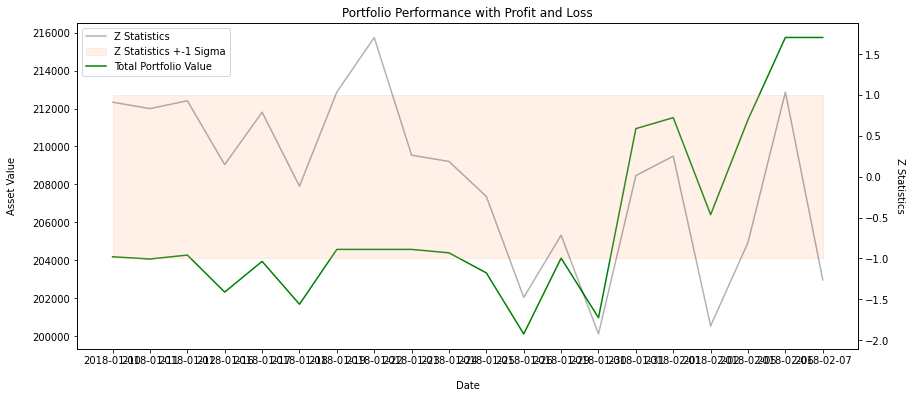

-------------------------------------------------------------------------------- 


------------------------------ ['FCX', 'SEE'] ------------------------------ 



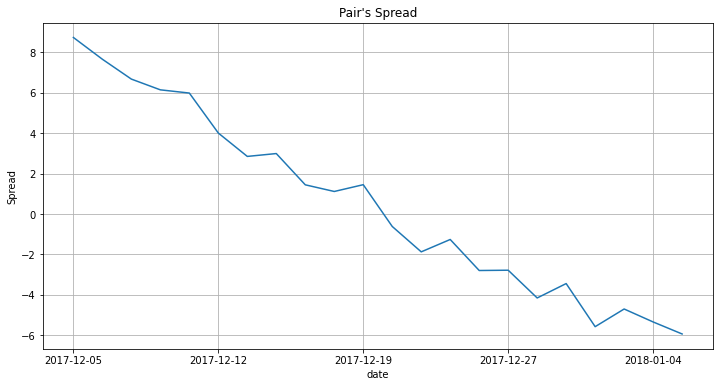

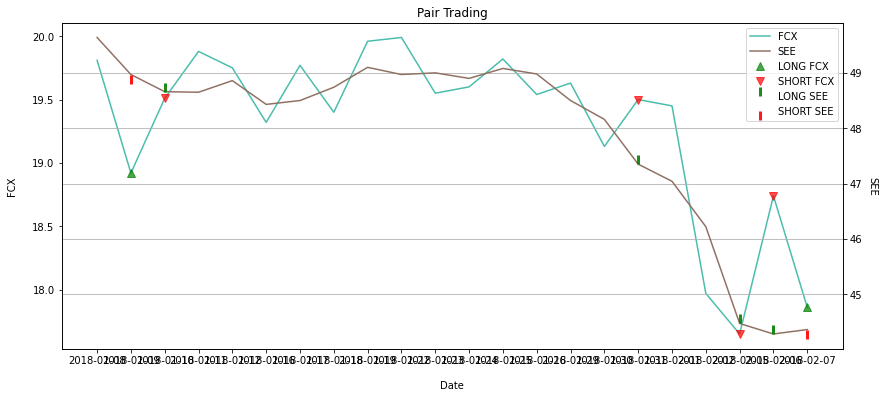

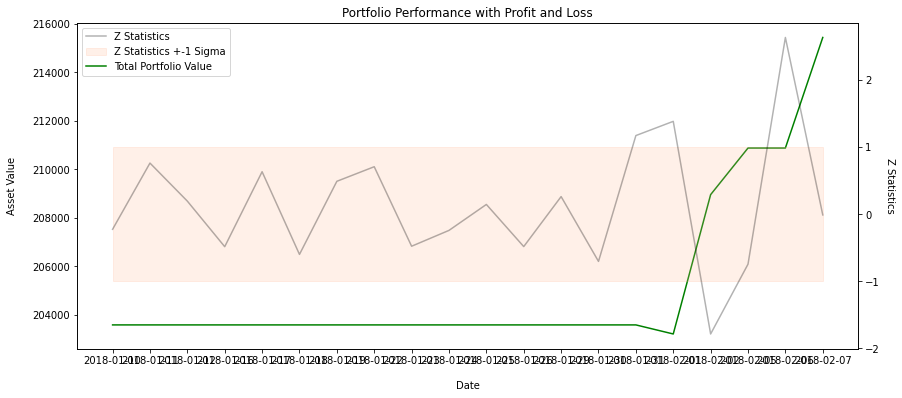

-------------------------------------------------------------------------------- 


------------------------------ ['GD', 'PH'] ------------------------------ 



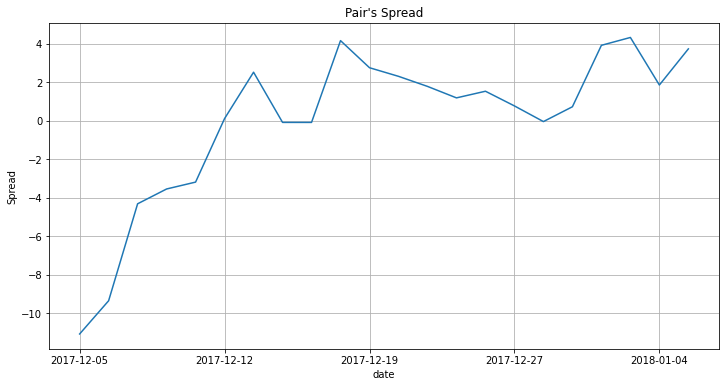

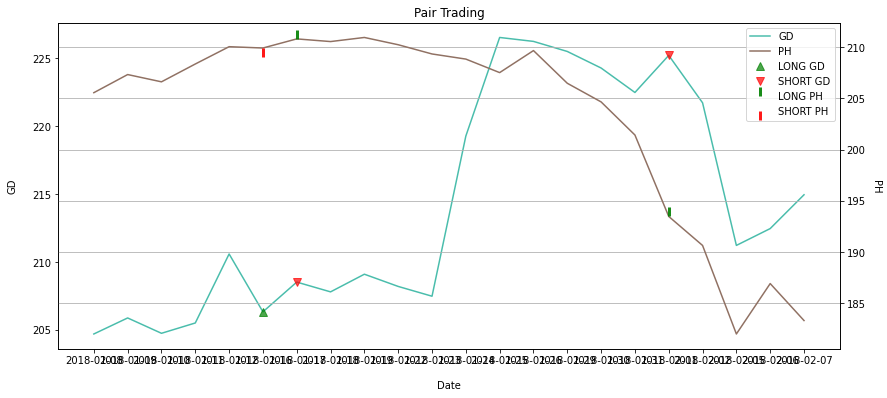

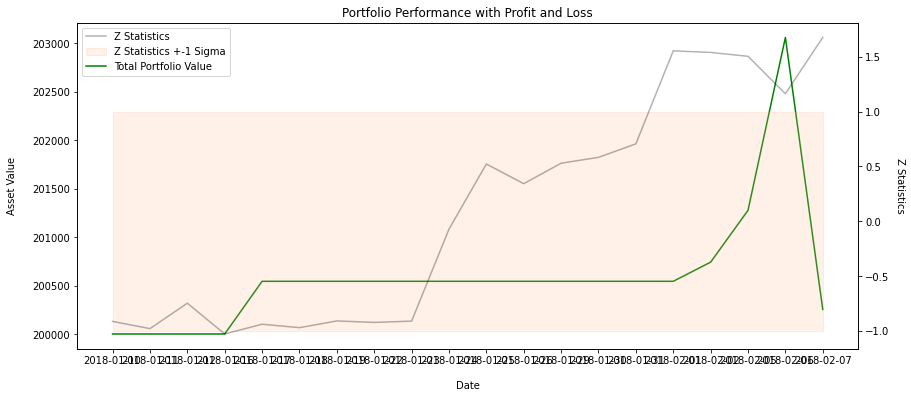

-------------------------------------------------------------------------------- 


------------------------------ ['CAT', 'RHI'] ------------------------------ 



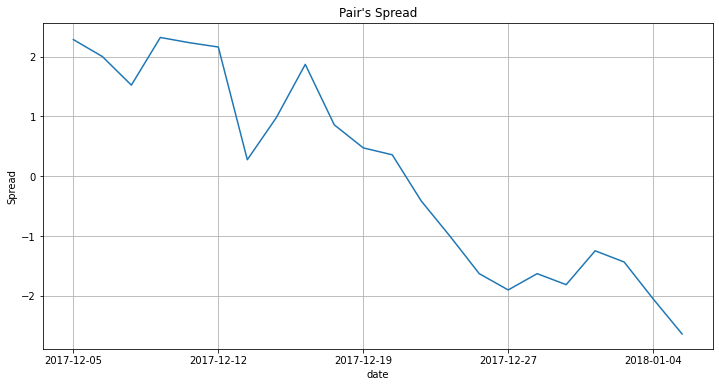

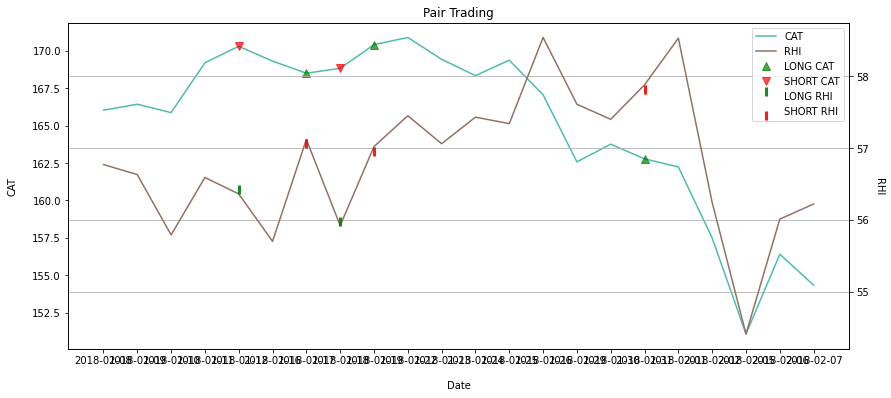

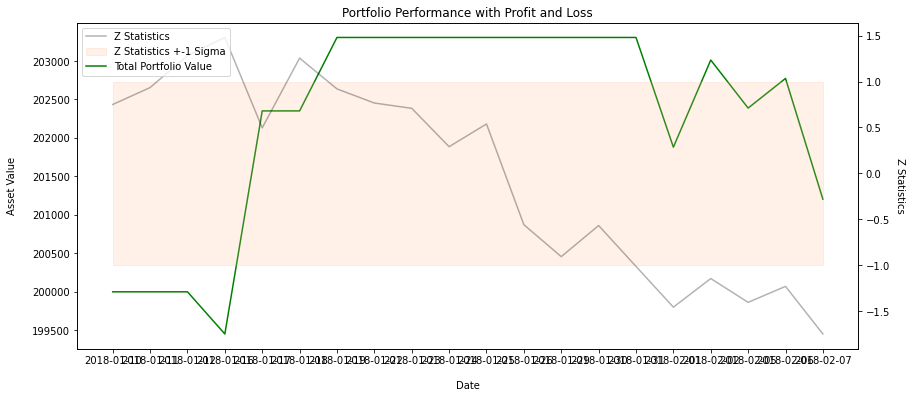

-------------------------------------------------------------------------------- 


------------------------------ ['CAT', 'UAL'] ------------------------------ 



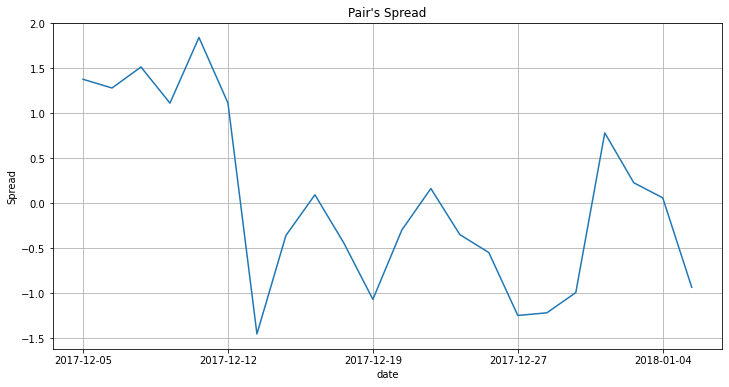

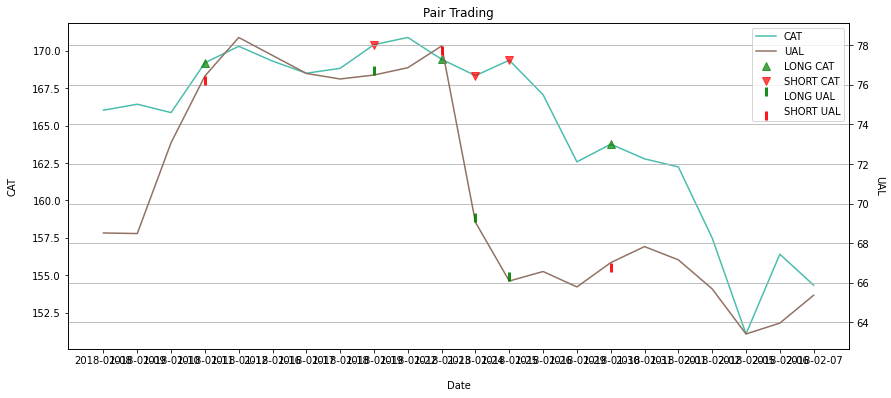

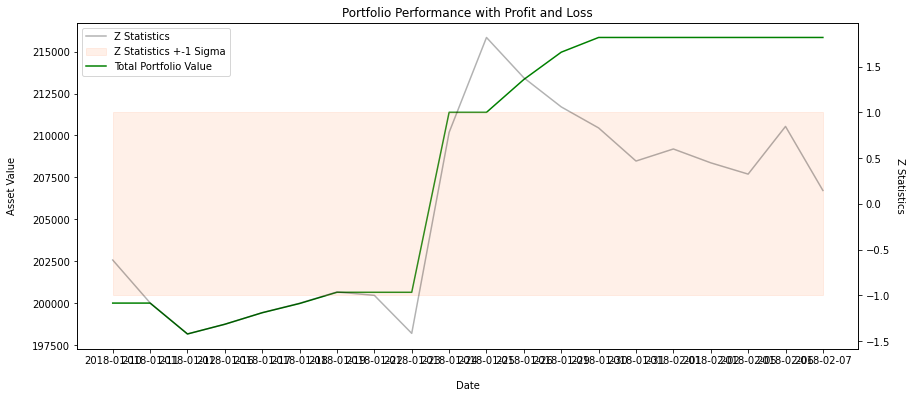

-------------------------------------------------------------------------------- 


------------------------------ ['C', 'CMA'] ------------------------------ 



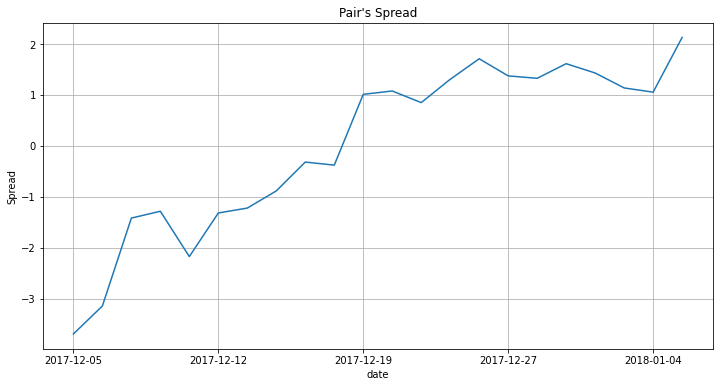

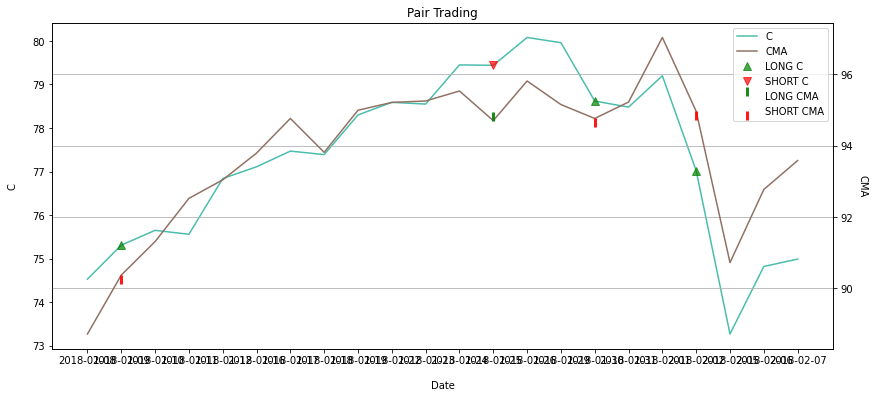

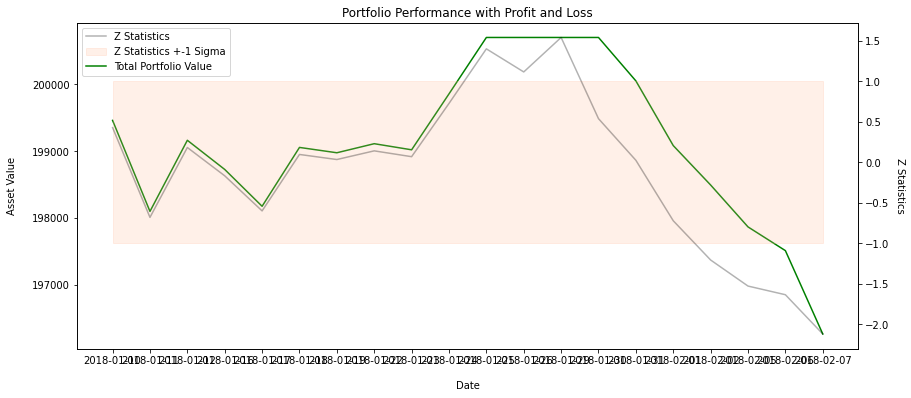

-------------------------------------------------------------------------------- 


------------------------------ ['AMP', 'AXP'] ------------------------------ 



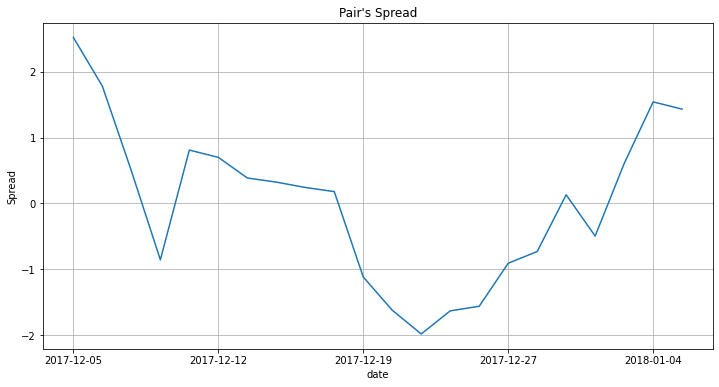

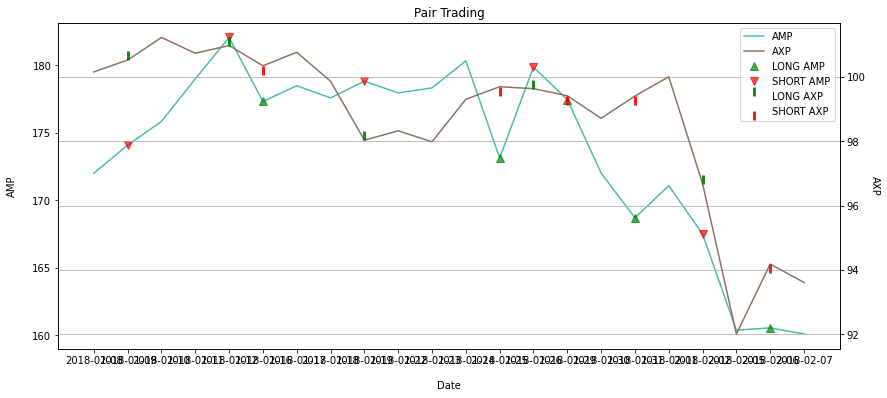

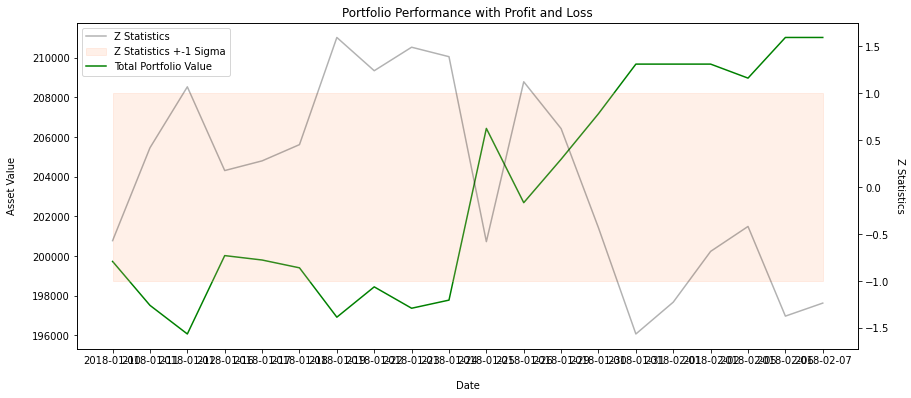

-------------------------------------------------------------------------------- 


------------------------------ ['LNC', 'RF'] ------------------------------ 



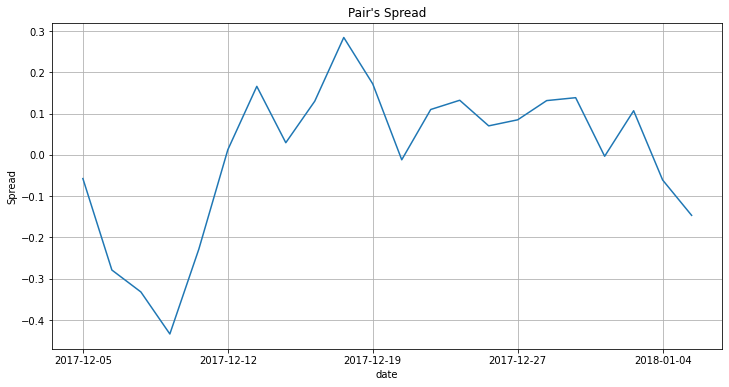

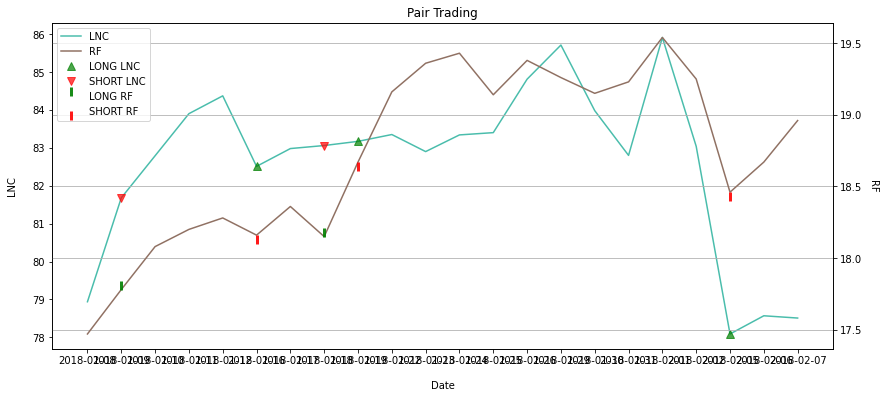

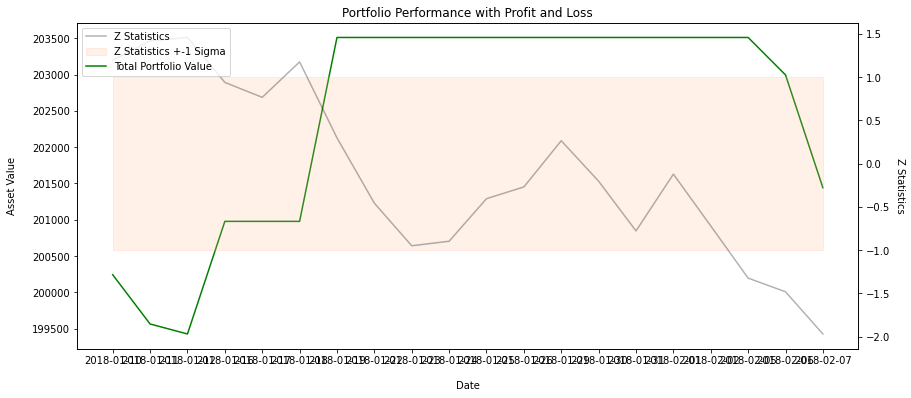

-------------------------------------------------------------------------------- 


------------------------------ ['FFIV', 'V'] ------------------------------ 



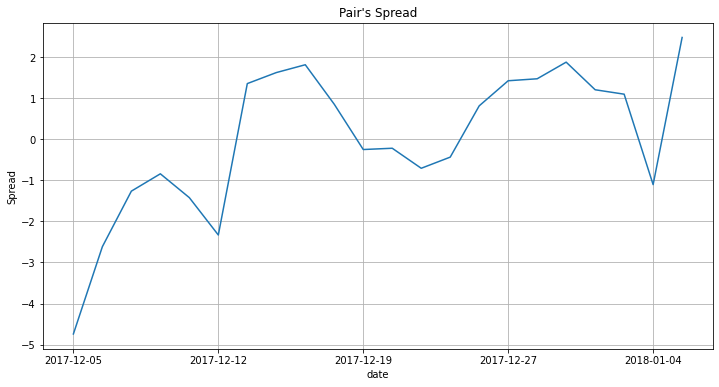

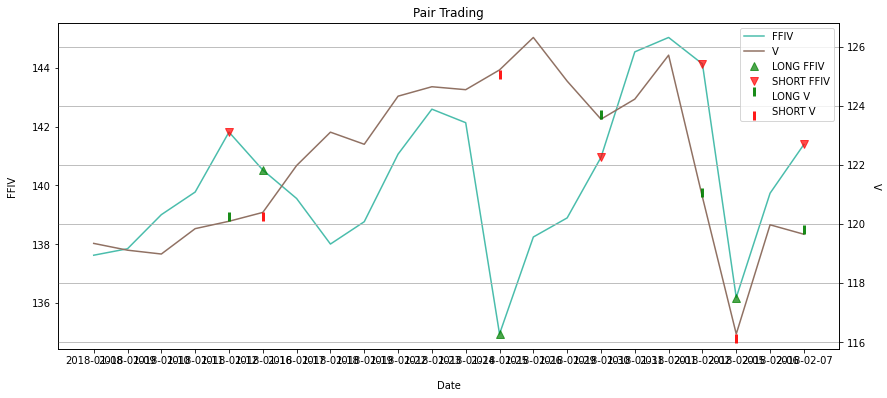

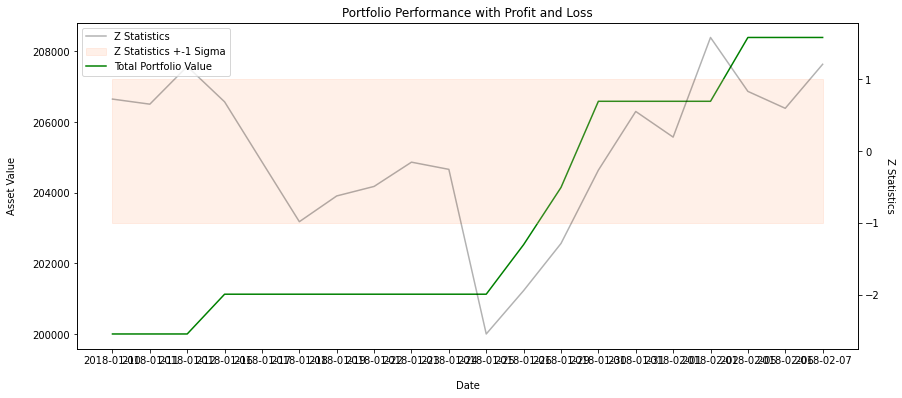

-------------------------------------------------------------------------------- 


------------------------------ ['AVGO', 'CTSH'] ------------------------------ 



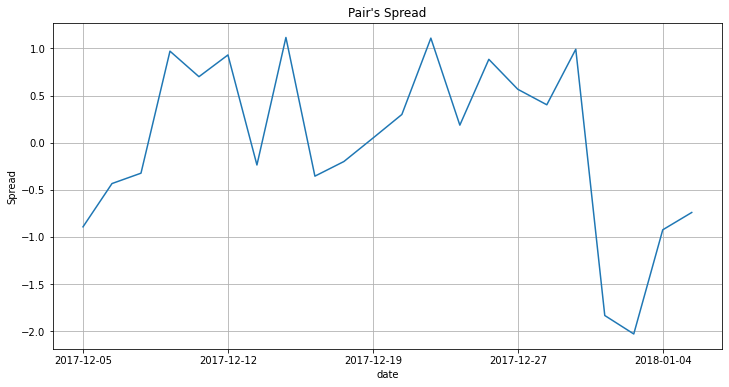

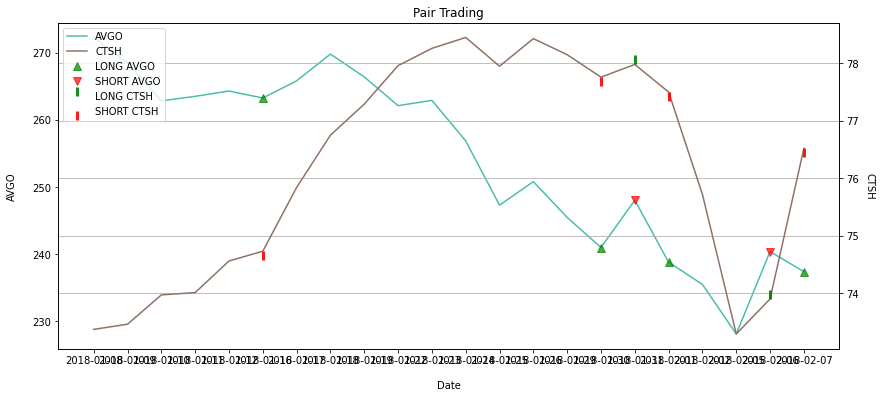

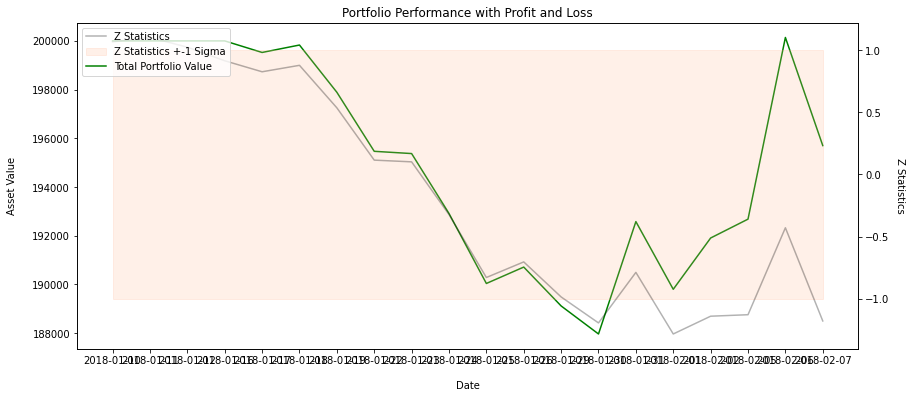

-------------------------------------------------------------------------------- 


------------------------------ ['FFIV', 'STX'] ------------------------------ 



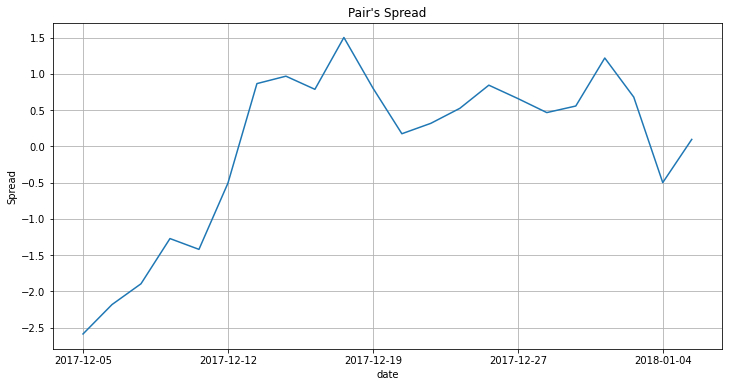

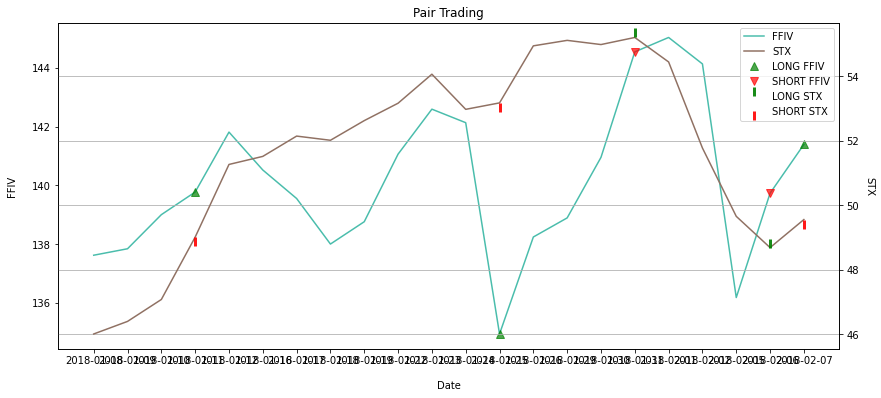

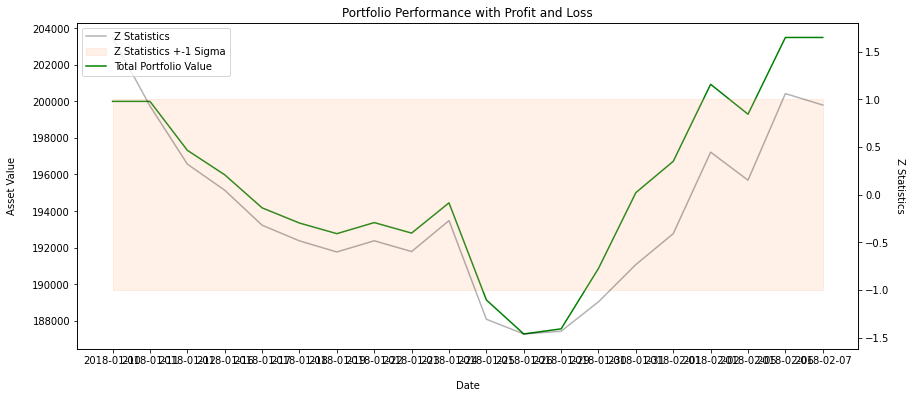

-------------------------------------------------------------------------------- 


------------------------------ ['CVX', 'MRO'] ------------------------------ 



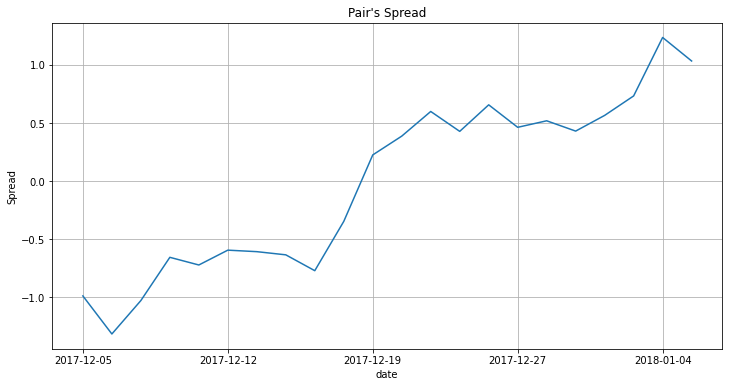

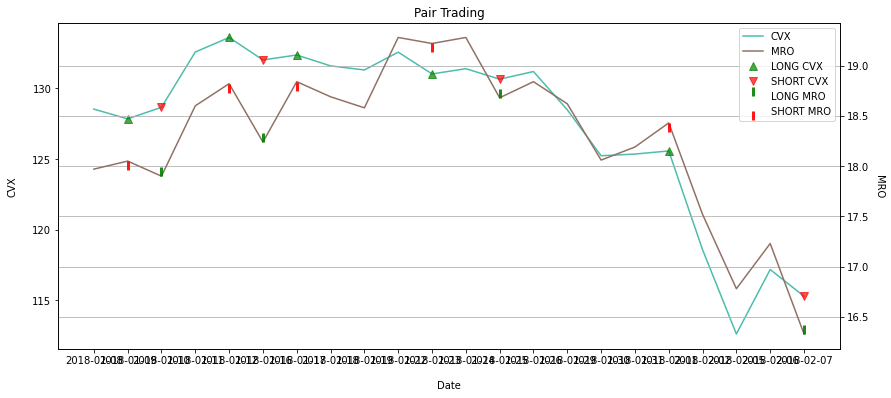

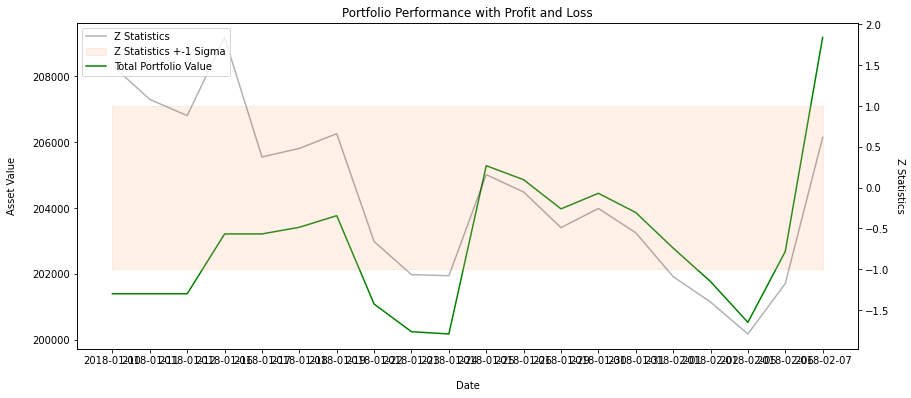

-------------------------------------------------------------------------------- 


------------------------------ ['APA', 'OXY'] ------------------------------ 



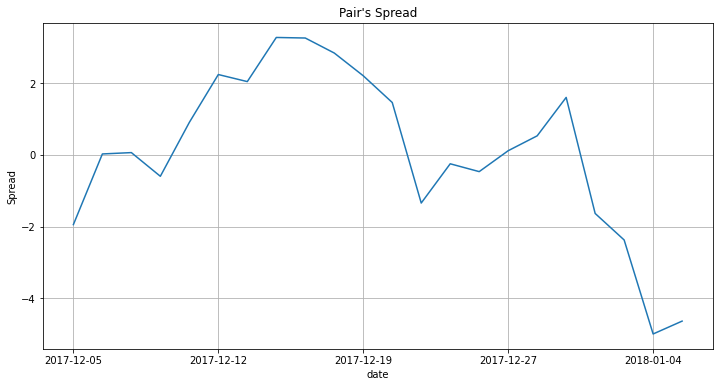

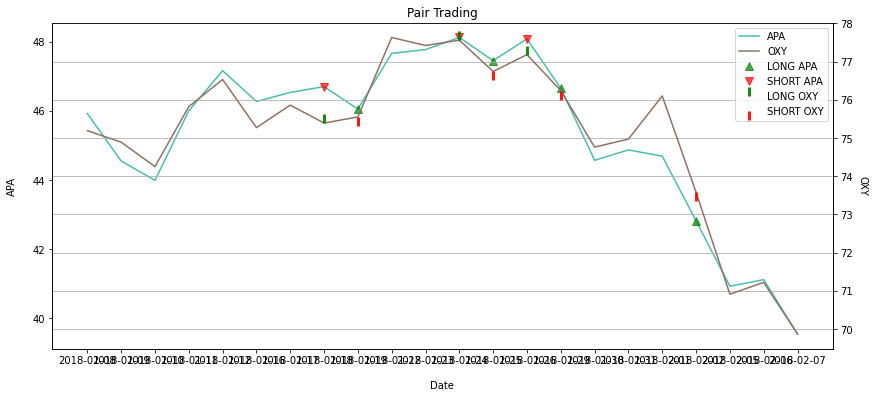

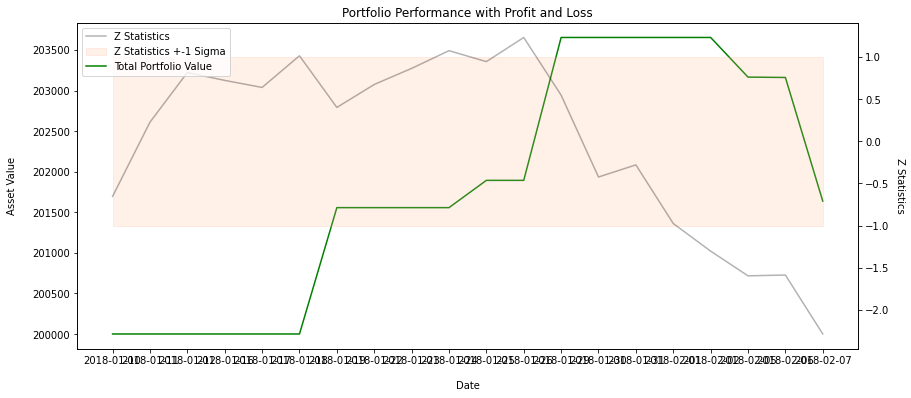

-------------------------------------------------------------------------------- 


------------------------------ ['HES', 'OKE'] ------------------------------ 



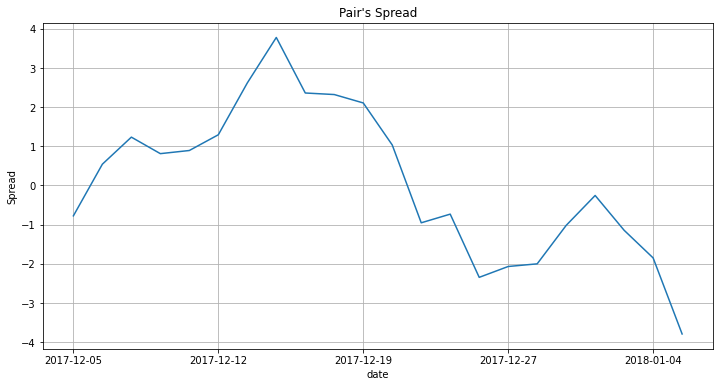

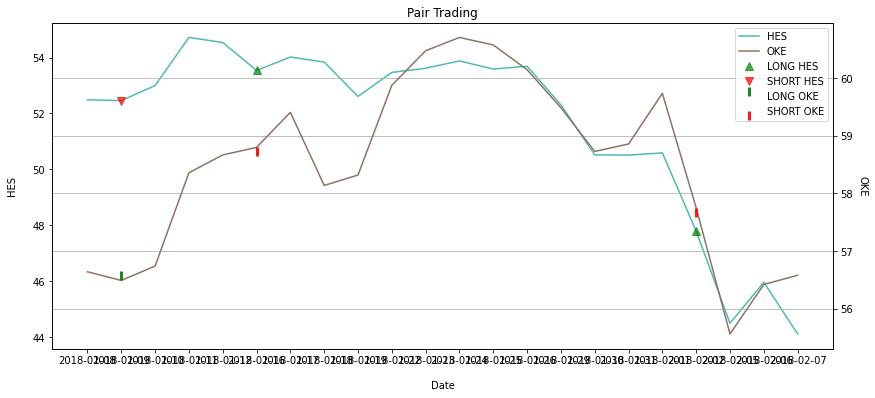

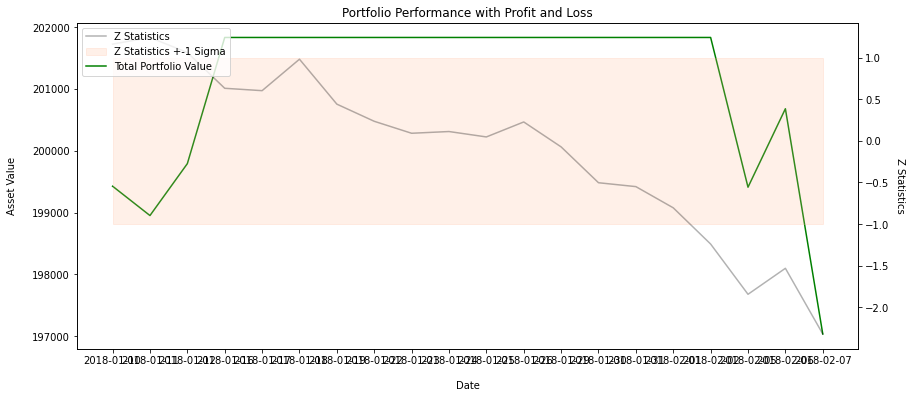

-------------------------------------------------------------------------------- 


------------------------------ ['ARE', 'EQR'] ------------------------------ 



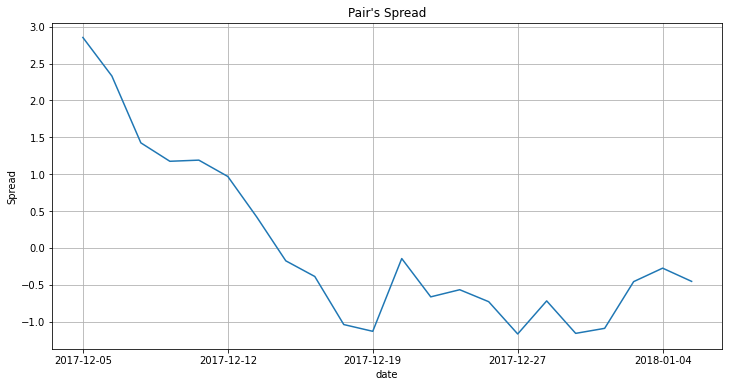

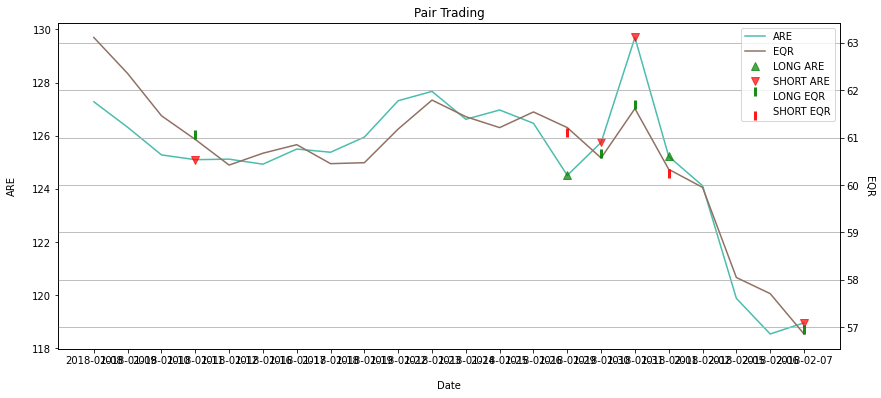

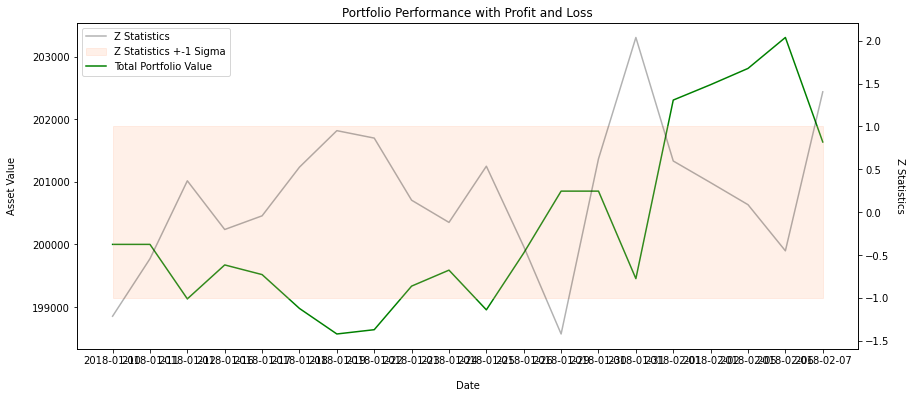

-------------------------------------------------------------------------------- 


------------------------------ ['CCI', 'ESS'] ------------------------------ 



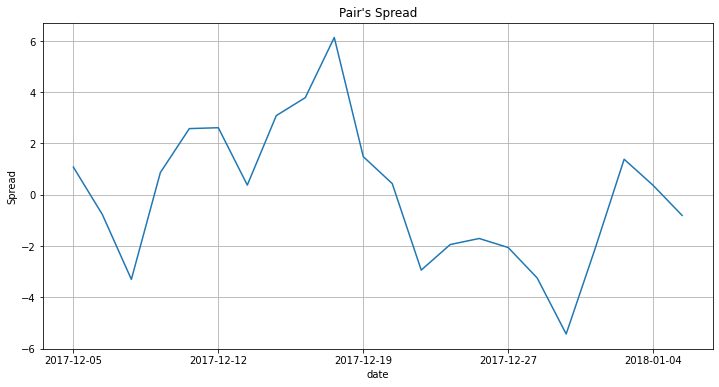

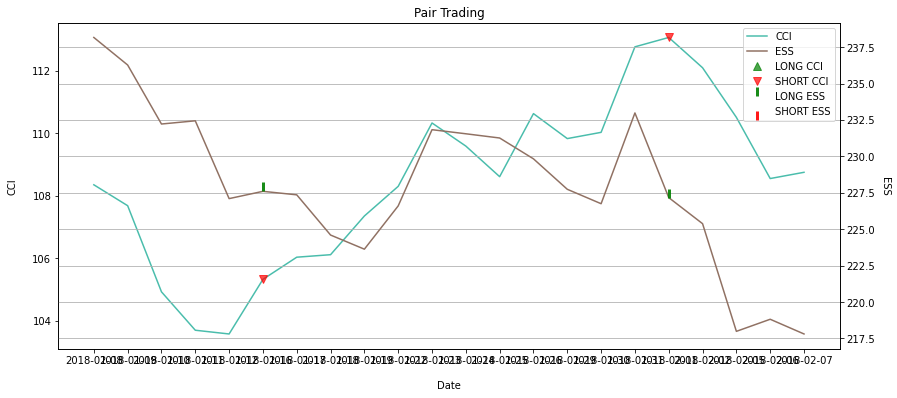

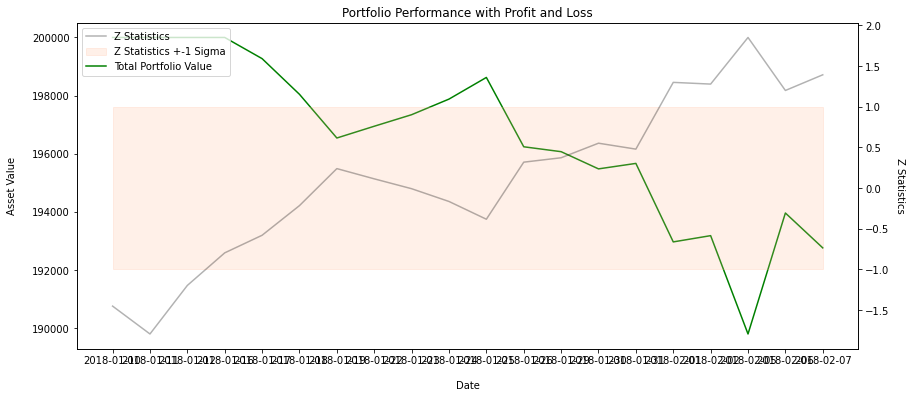

-------------------------------------------------------------------------------- 


------------------------------ ['CCI', 'FRT'] ------------------------------ 



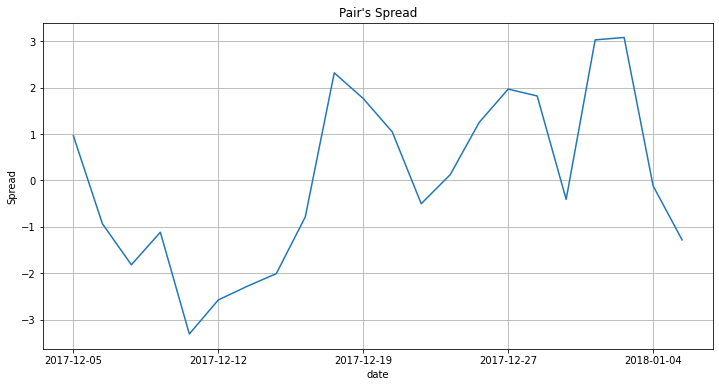

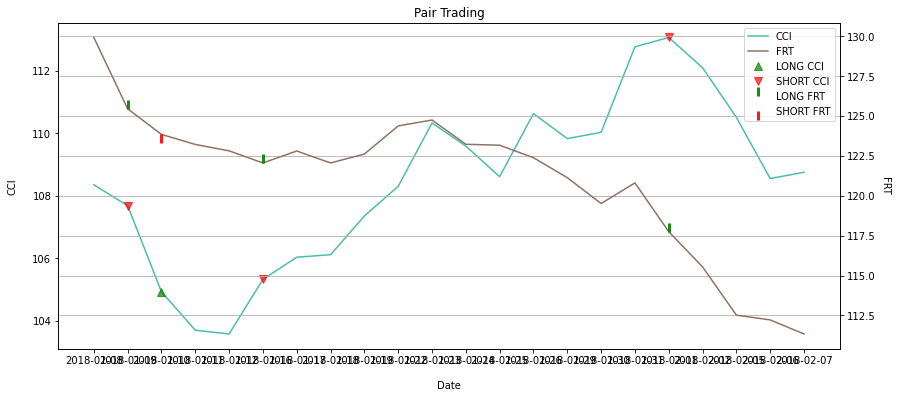

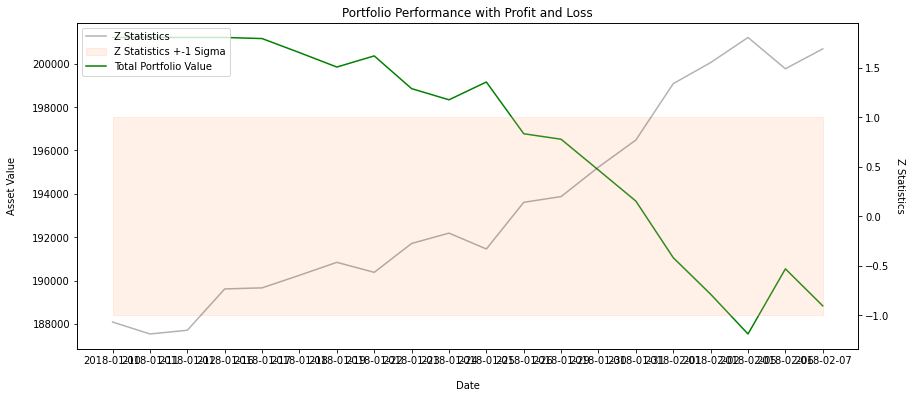

-------------------------------------------------------------------------------- 




In [67]:
# Perform ADF on high;ly cointegrated pairs of each sector
# Further analyse their spread using z-score and visualizetrading signals and profit and loss. 

def main_sec(stocks,sec_wise_pairs):
  close = stocks.unstack(['Name'])['close'].sort_index()
  close = close.dropna()
  close.head(2)

  # train test split 
  train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

  # quick view of head and tail of train set
  train_close.head(2).append(train_close.tail(2))


  for pair in sec_wise_pairs:
    print("-"*30,pair,"-"*30,"\n")
    pair_test(pair,train_close)
    returns = trading_signals(pair,test_close)
    top_stocks[tuple(pair)] = returns
    print("-"*80,"\n\n")

stock_data = pd.read_csv("/content/all_stocks_5yr.csv")
industries = secWise_pairs_dict.keys()

for industry in industries:
  main_sec(stock_data.set_index(['Name','date']),secWise_pairs_dict[industry])

In [ ]:
pip install yfinance

In [ ]:
## To get Yahoo finance data 
yf_data = yf.download(  
        tickers = cobrand_pairs,
        period = "ytd",
        interval = "1d",
        auto_adjust = True,
        prepost = True,
        proxy = None,
        start="2013-01-01", end="2020-12-31"
)

------------------------------ ['NFLX', 'AMZN'] ------------------------------ 



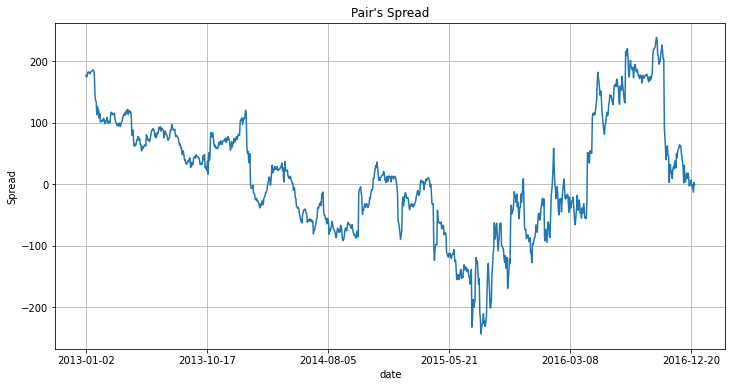

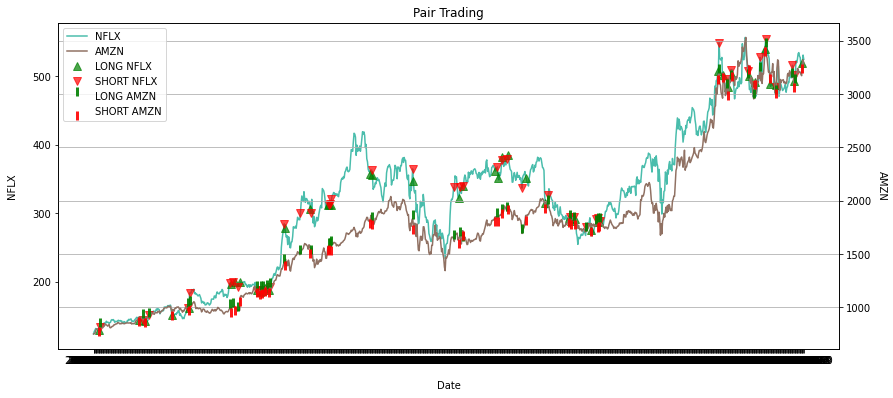

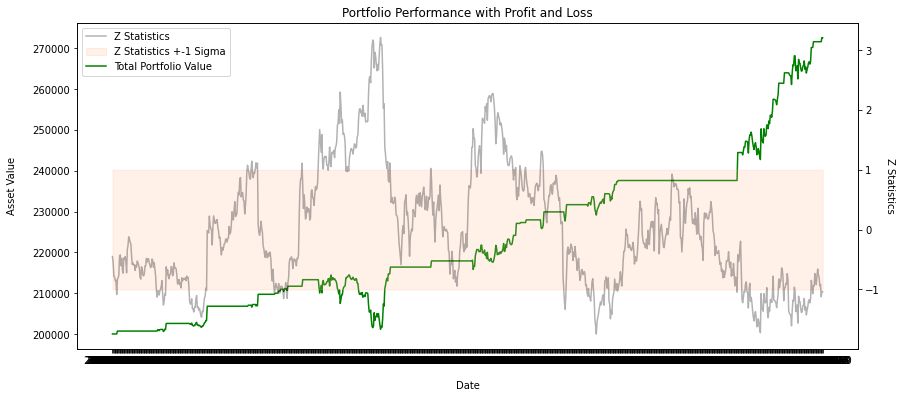

-------------------------------------------------------------------------------- 


------------------------------ ['AMZN', 'CRM'] ------------------------------ 



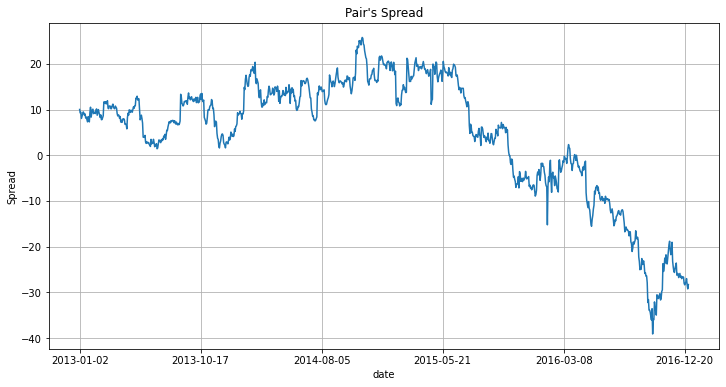

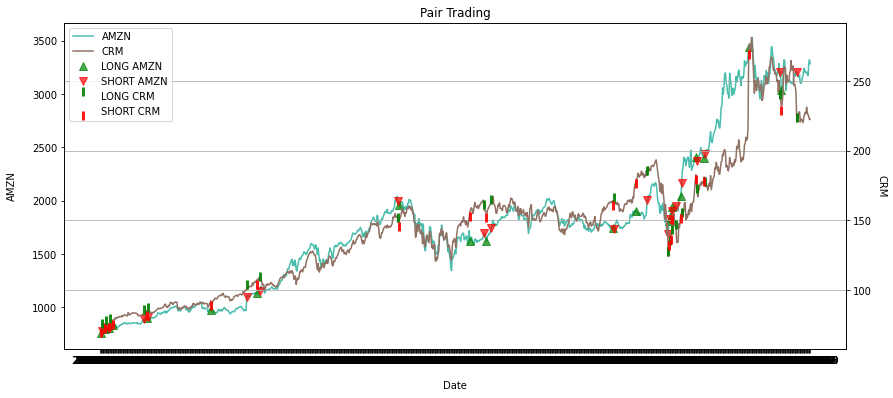

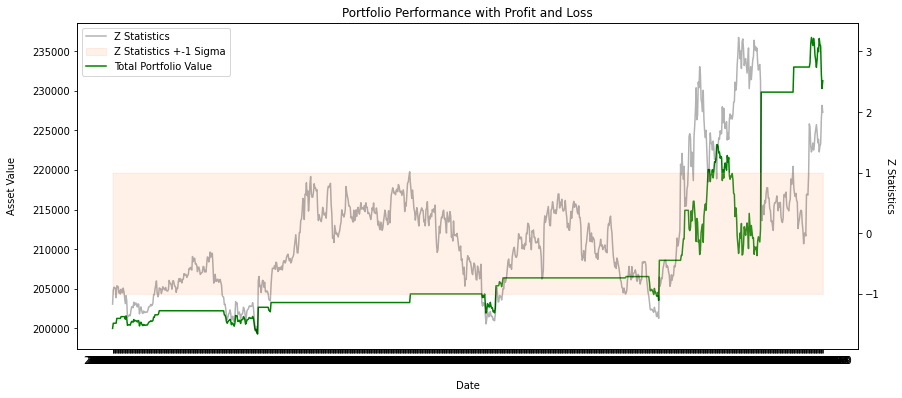

-------------------------------------------------------------------------------- 


------------------------------ ['QCOM', 'TSM'] ------------------------------ 



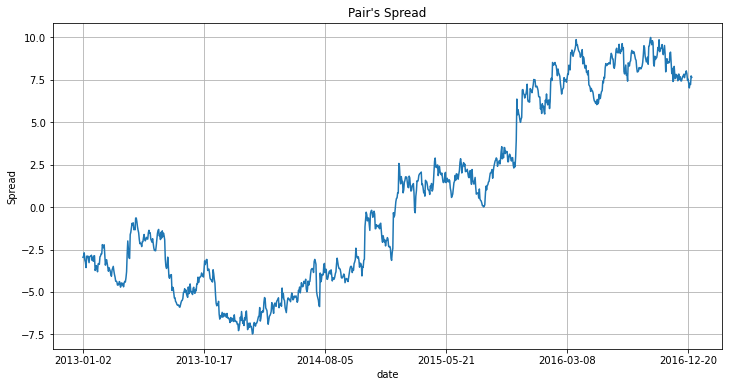

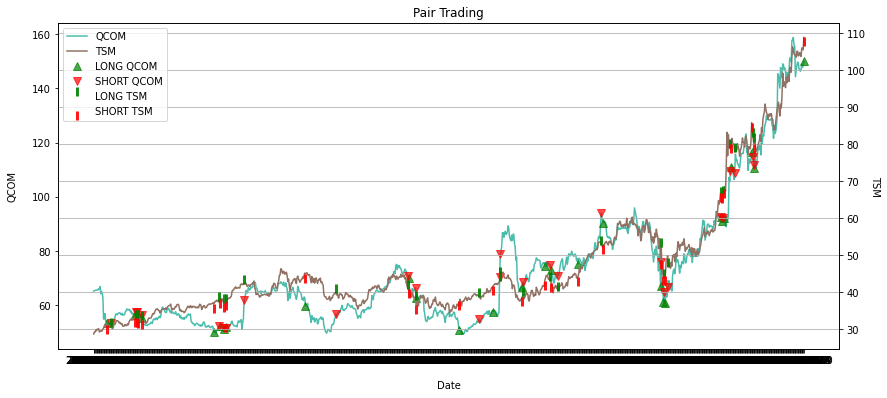

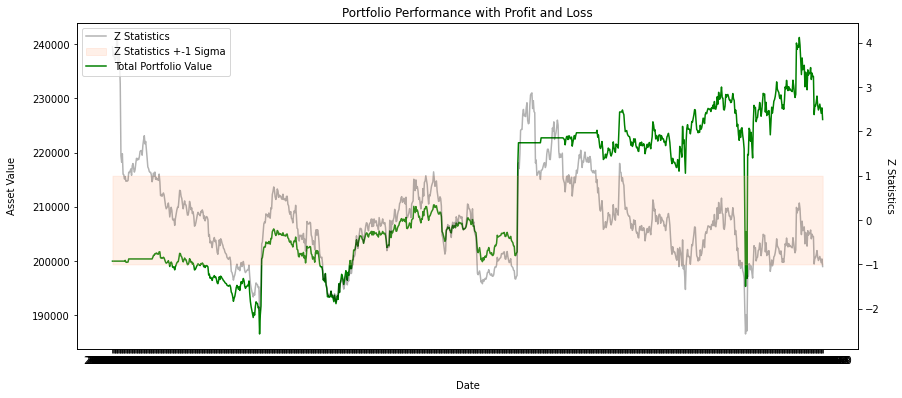

-------------------------------------------------------------------------------- 




In [51]:
#  Analyse the spread using z-score and visualize trading signals and profit and loss of top co branded pairs.

yf_Data = pd.read_csv("/content/yahoo_Data_coBrand.csv")
def main_cobranding(stocks):
  close = stocks.unstack(['Name'])['close'].sort_index()
  close = close.dropna()
  close.head(2)

  # train test split 
  train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

  # quick view of head and tail of train set
  train_close.head(2).append(train_close.tail(2))

  global top_stocks
  top_stocks = {}
  # cobranding_pairs = [['NVDA','TSM'],['BMWYY','LVMUY'],['NKE','AAPL'],['NFLX','AMZN'],['MSFT','AMZN'],['FB','AMZN'],['FB','AMZN'],['FB','MSFT'],['QCOM','TSM'],['QCOM','AAPL'],['REI','SPLK'],['AMZN','CRM']]
  top_pair_coBrand = [['NFLX','AMZN'],['AMZN','CRM'],['QCOM','TSM']]

  for pair in top_pair_coBrand:
    print("-"*30,pair,"-"*30,"\n")
    pair_test(pair,train_close)
    returns = trading_signals(pair,test_close)
    top_stocks[tuple(pair)] = returns
    print("-"*80,"\n\n")

main_cobranding(yf_Data.set_index(['Name','date']))

-------------------------------------------------- ['IEX', 'LEN'] -------------------------------------------------- 




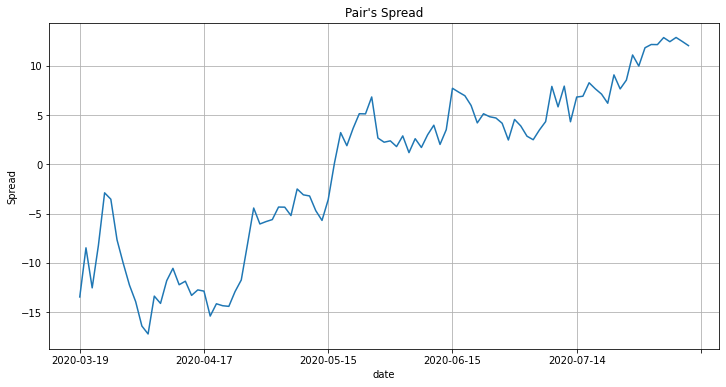

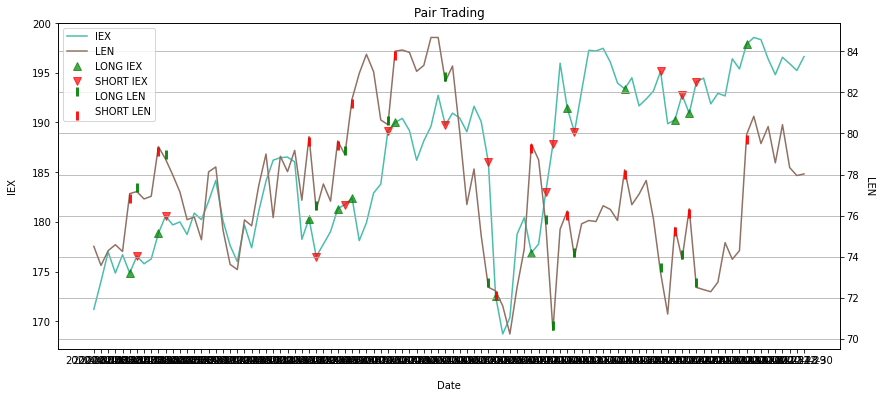

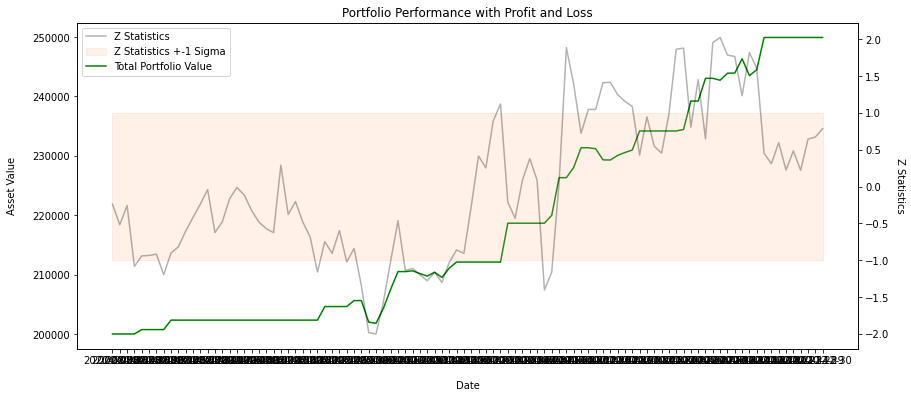

------------------------------------------------------------------------------------------------------------------------------------------------------ 


-------------------------------------------------- ['DRE', 'SWKS'] -------------------------------------------------- 




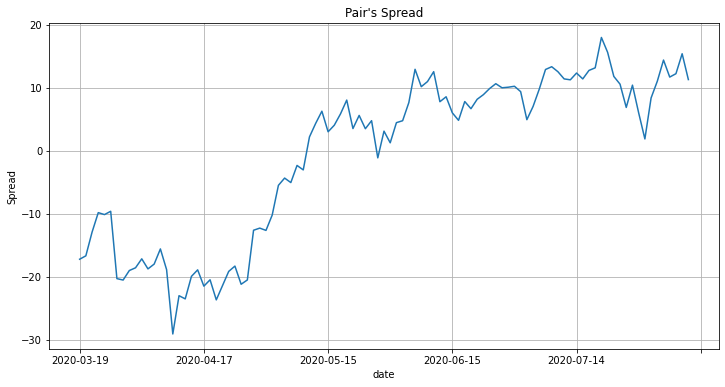

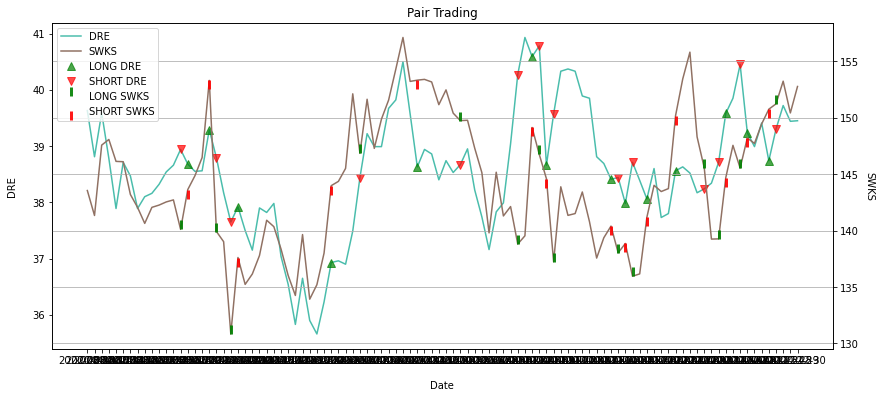

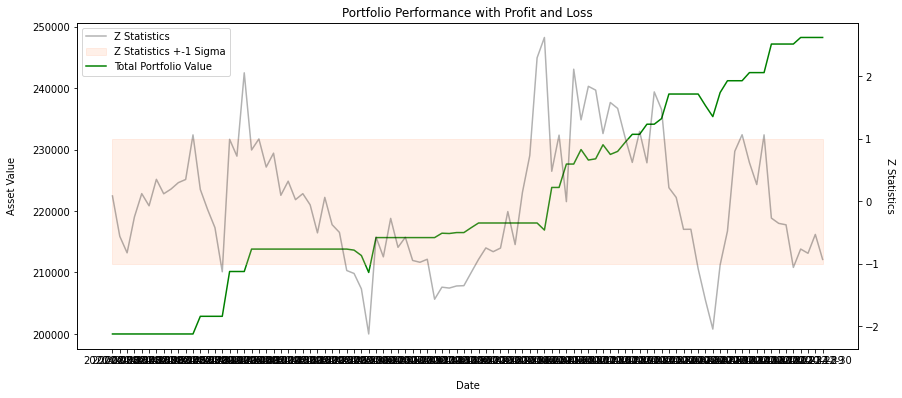

------------------------------------------------------------------------------------------------------------------------------------------------------ 


-------------------------------------------------- ['LEN', 'LOW'] -------------------------------------------------- 




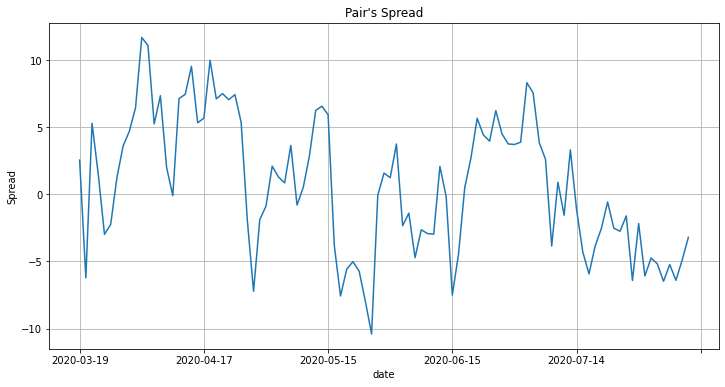

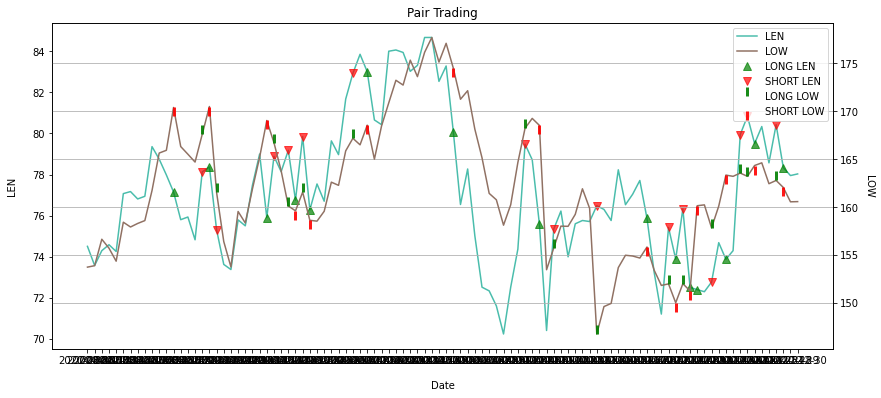

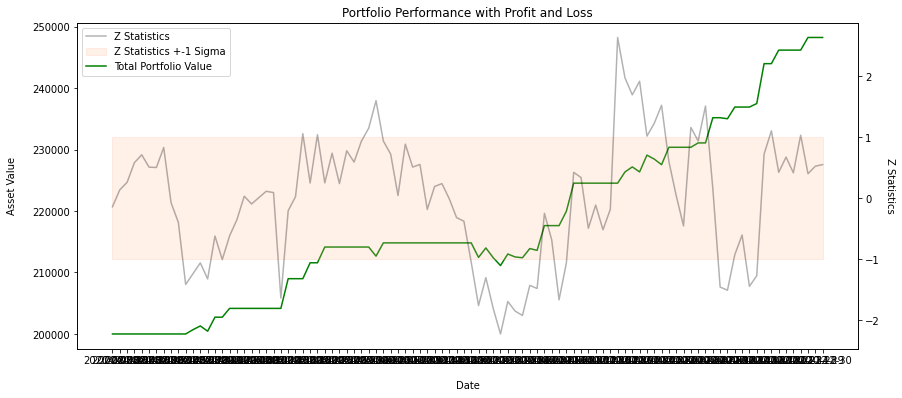

------------------------------------------------------------------------------------------------------------------------------------------------------ 




In [53]:
#  Analyse the spread using z-score and visualize trading signals and profit and loss of top correlated-cointegrated pairs.

yf_corrCointPair_data = pd.read_csv("/content/yahoo_Data_corrCointPair.csv")
def main_yf(stocks):
  close = stocks.unstack(['Name'])['close'].sort_index()
  close = close.dropna()
  close.head(2)

  # train test split 
  train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

  # quick view of head and tail of train set
  train_close.head(2).append(train_close.tail(2))

  # global top_pairs_corrCointPair 
  # top_pairs_corrCointPair = {}
  top_pairs_corrCointPair = [['IEX', 'LEN'],['DRE', 'SWKS'],['LEN', 'LOW']]
  for pair in top_pairs_corrCointPair:
    print("-"*50,pair,"-"*50,"\n\n")
    pair_test(pair,train_close)
    trading_signals(pair,test_close)
    print("-"*150,"\n\n")

main_yf(yf_corrCointPair_data.set_index(['Name','date']))



 **************************************** ['SBUX', 'VFC'] ****************************************


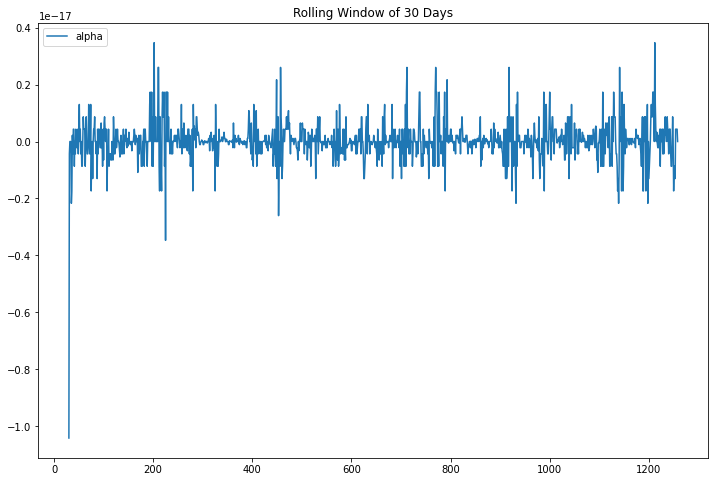

**************************************************************************************************** 




 **************************************** ['EBAY', 'LEN'] ****************************************


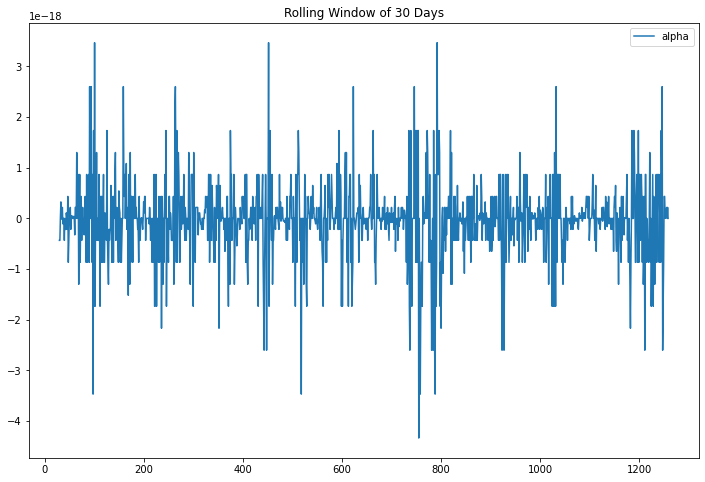

**************************************************************************************************** 




 **************************************** ['EXPE', 'ULTA'] ****************************************


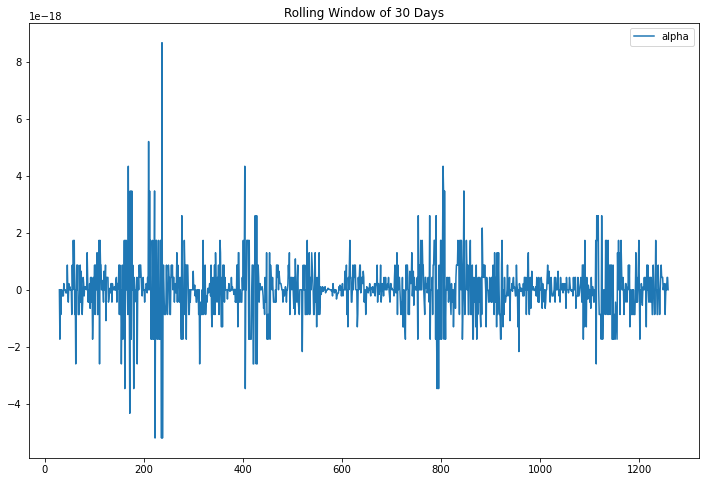

**************************************************************************************************** 




 **************************************** ['IQV', 'LLY'] ****************************************


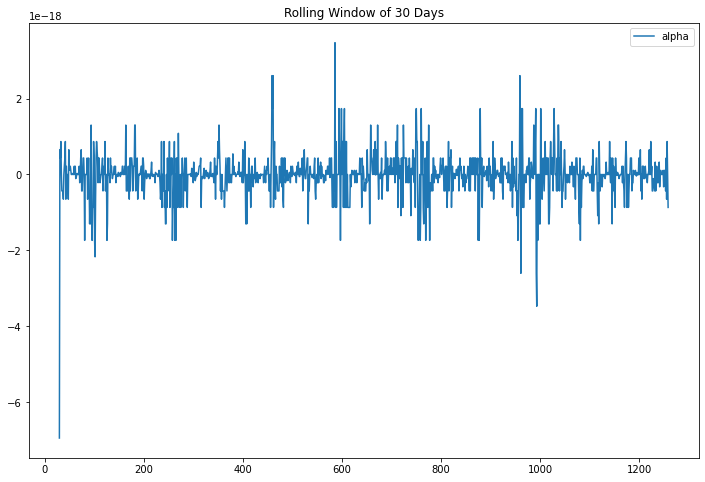

**************************************************************************************************** 




 **************************************** ['BDX', 'MDT'] ****************************************


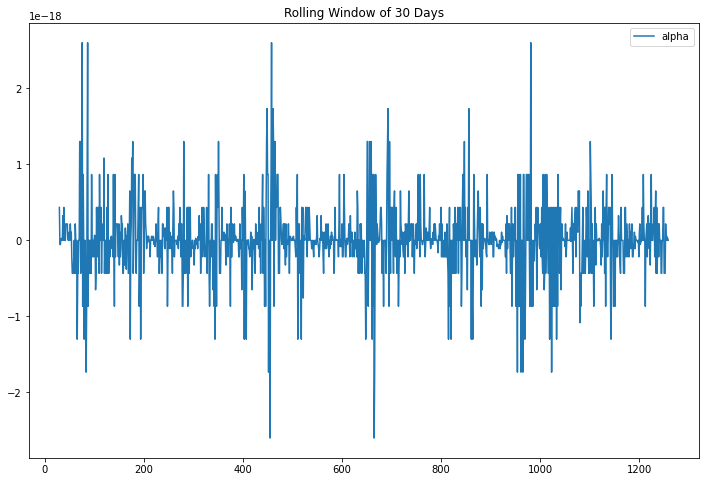

**************************************************************************************************** 




 **************************************** ['BDX', 'CVS'] ****************************************


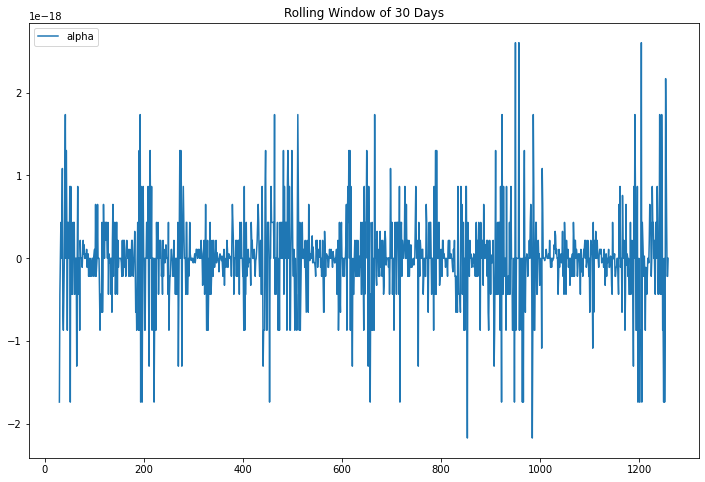

**************************************************************************************************** 




 **************************************** ['CMCSA', 'DIS'] ****************************************


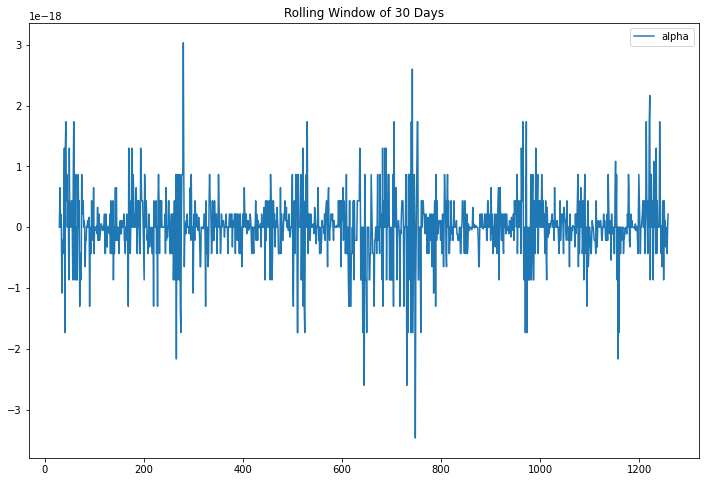

**************************************************************************************************** 




 **************************************** ['CMCSA', 'EA'] ****************************************


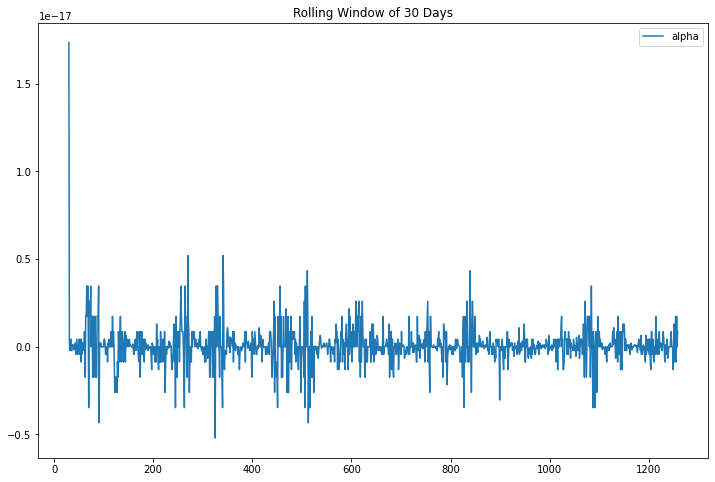

**************************************************************************************************** 




 **************************************** ['CHTR', 'EA'] ****************************************


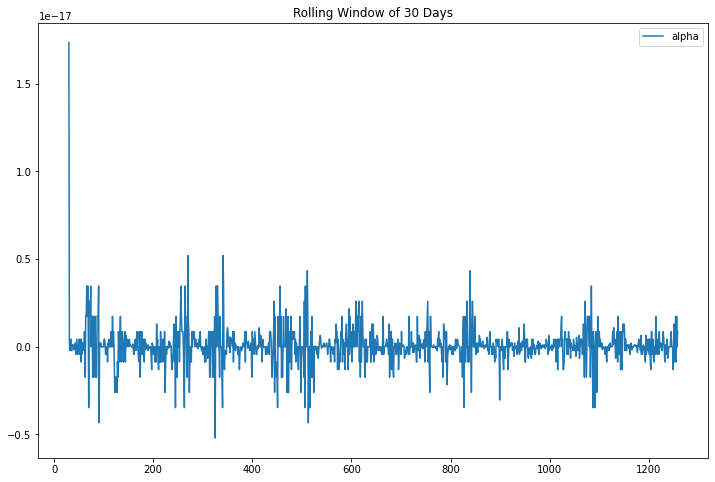

**************************************************************************************************** 




 **************************************** ['ES', 'WEC'] ****************************************


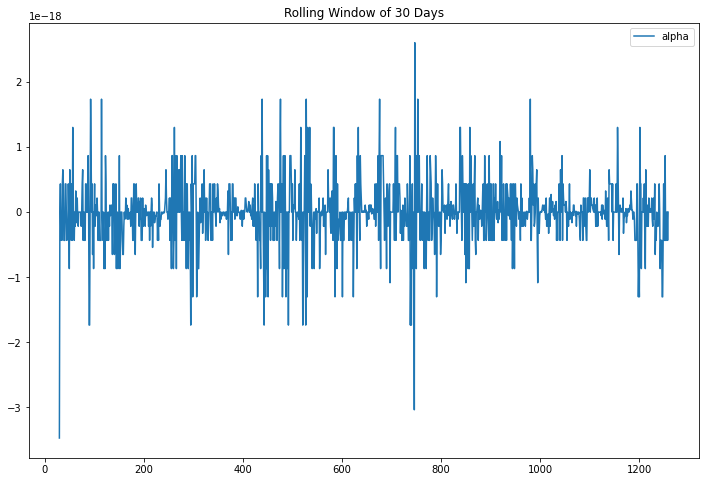

**************************************************************************************************** 




 **************************************** ['DTE', 'EIX'] ****************************************


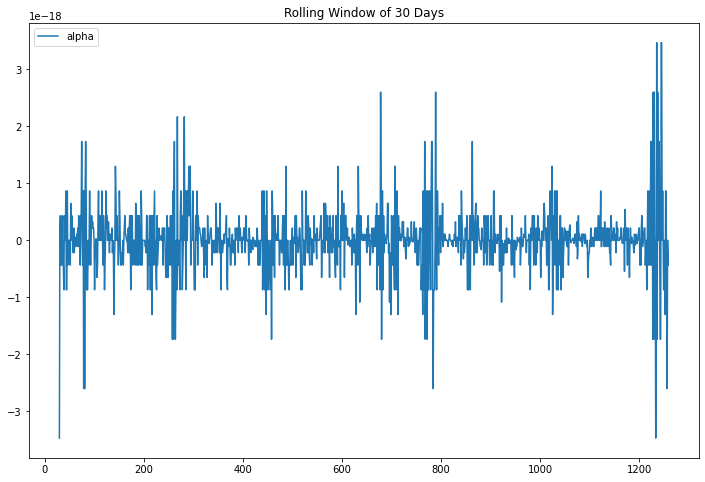

**************************************************************************************************** 




 **************************************** ['CMS', 'XEL'] ****************************************


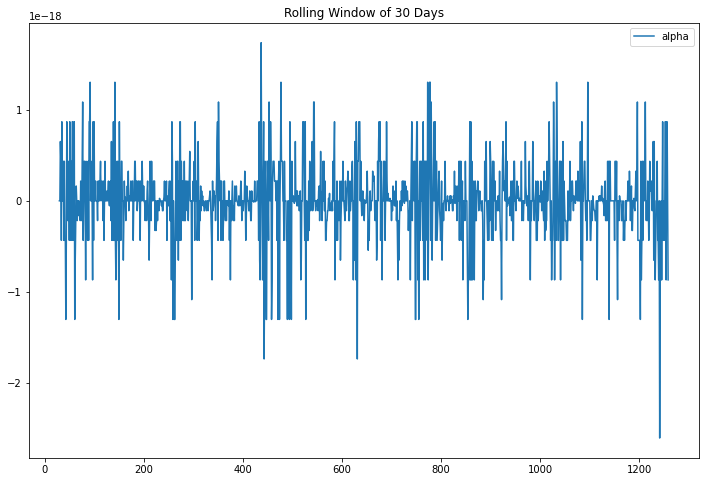

**************************************************************************************************** 




 **************************************** ['EL', 'KO'] ****************************************


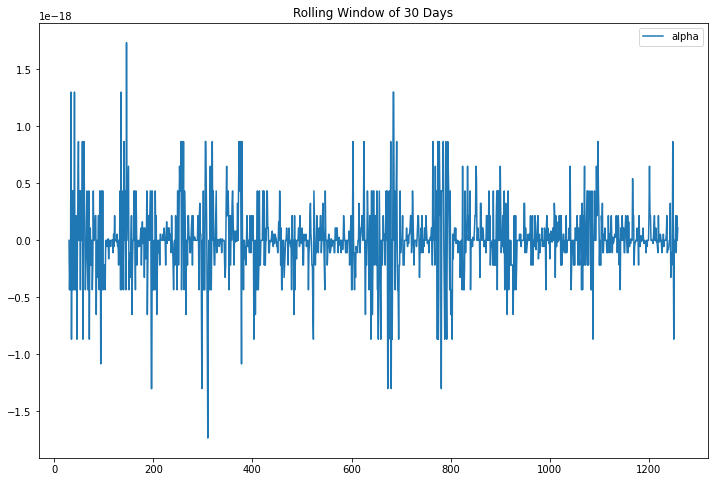

**************************************************************************************************** 




 **************************************** ['CLX', 'WBA'] ****************************************


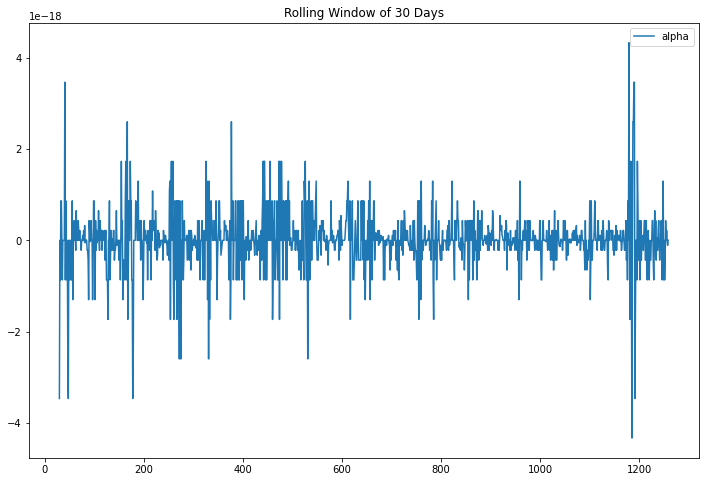

**************************************************************************************************** 




 **************************************** ['K', 'SJM'] ****************************************


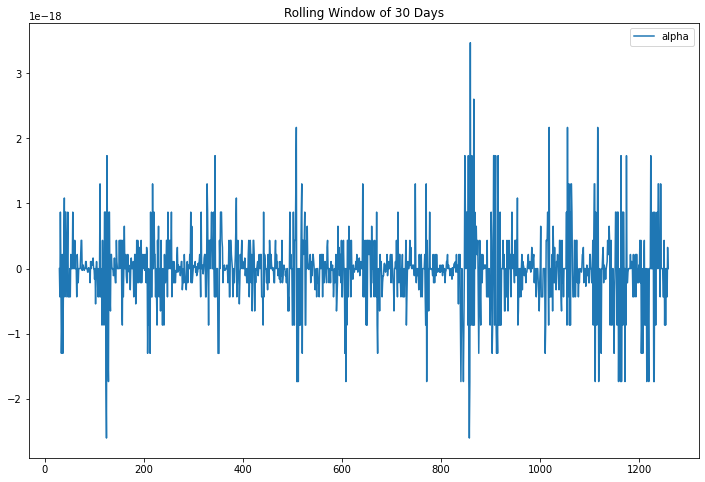

**************************************************************************************************** 




 **************************************** ['FCX', 'MLM'] ****************************************


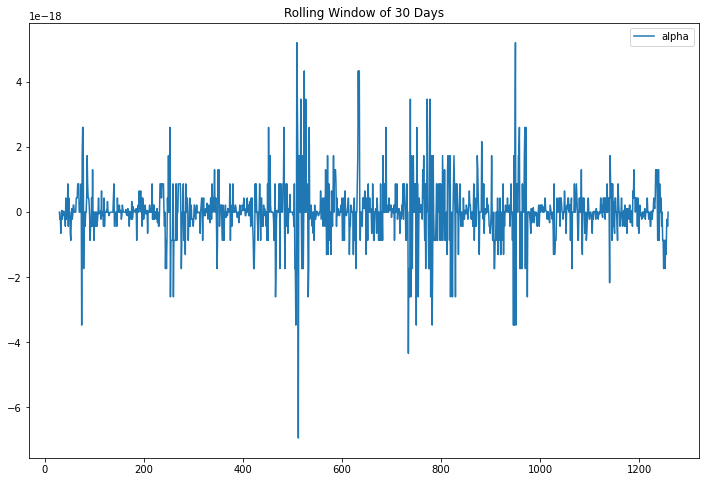

**************************************************************************************************** 




 **************************************** ['FCX', 'VMC'] ****************************************


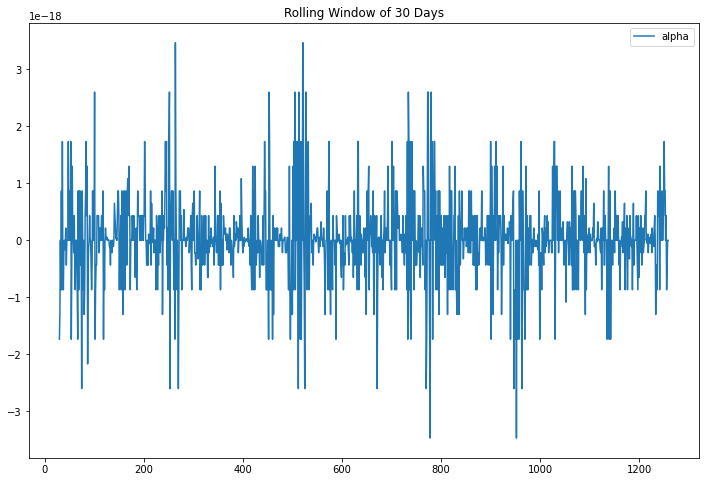

**************************************************************************************************** 




 **************************************** ['FCX', 'SEE'] ****************************************


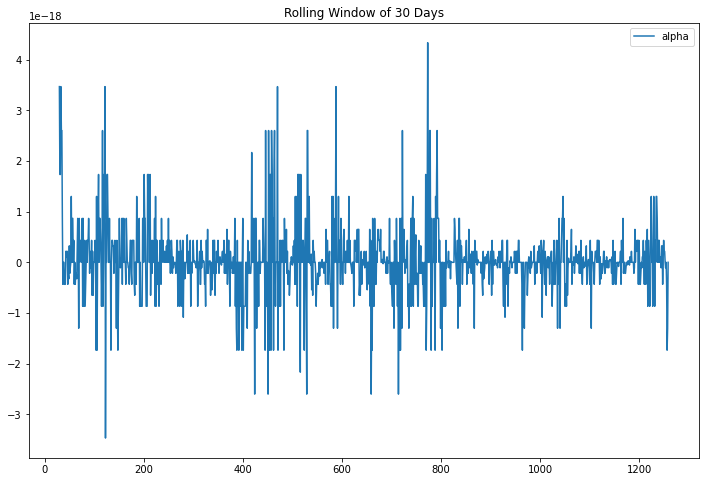

**************************************************************************************************** 




 **************************************** ['GD', 'PH'] ****************************************


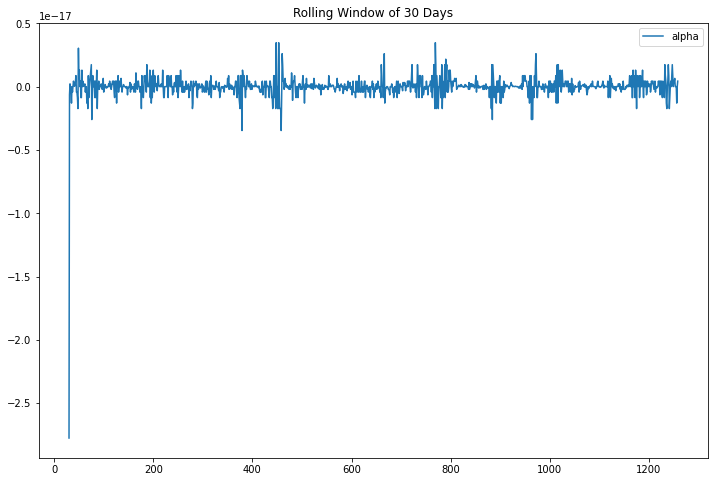

**************************************************************************************************** 




 **************************************** ['CAT', 'RHI'] ****************************************


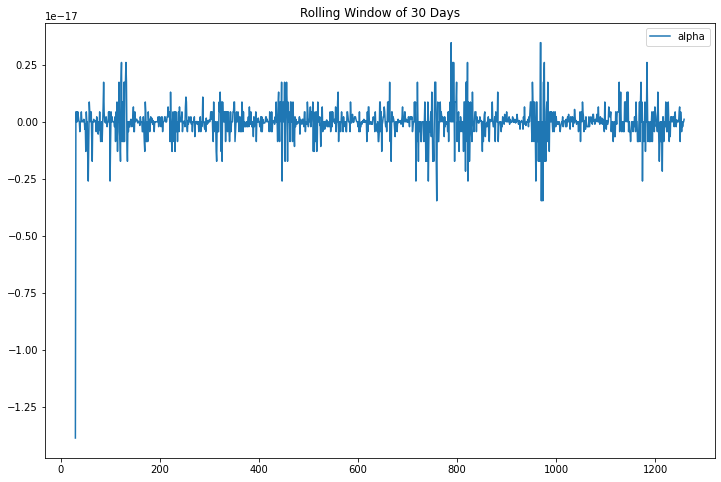

**************************************************************************************************** 




 **************************************** ['CAT', 'UAL'] ****************************************


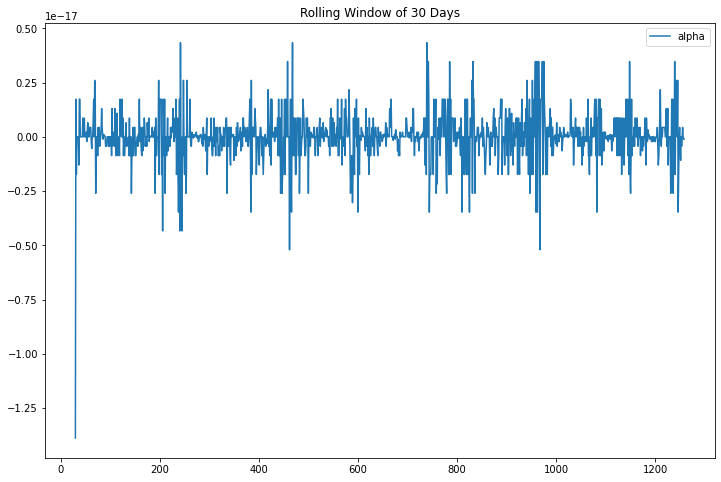

**************************************************************************************************** 




 **************************************** ['C', 'CMA'] ****************************************


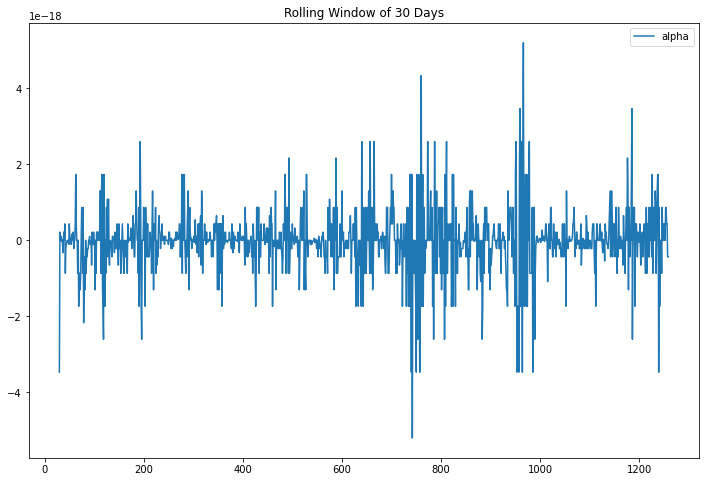

**************************************************************************************************** 




 **************************************** ['AMP', 'AXP'] ****************************************


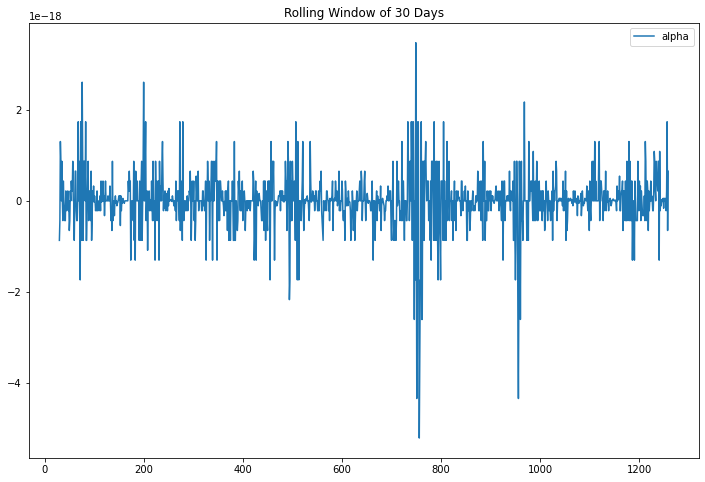

**************************************************************************************************** 




 **************************************** ['LNC', 'RF'] ****************************************


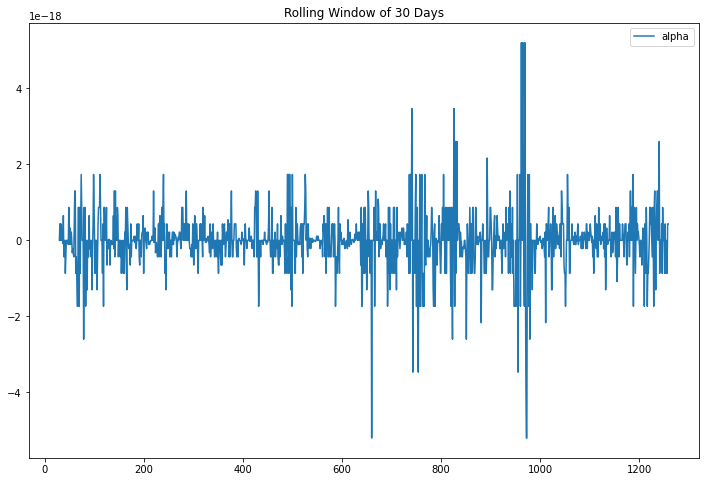

**************************************************************************************************** 




 **************************************** ['FFIV', 'V'] ****************************************


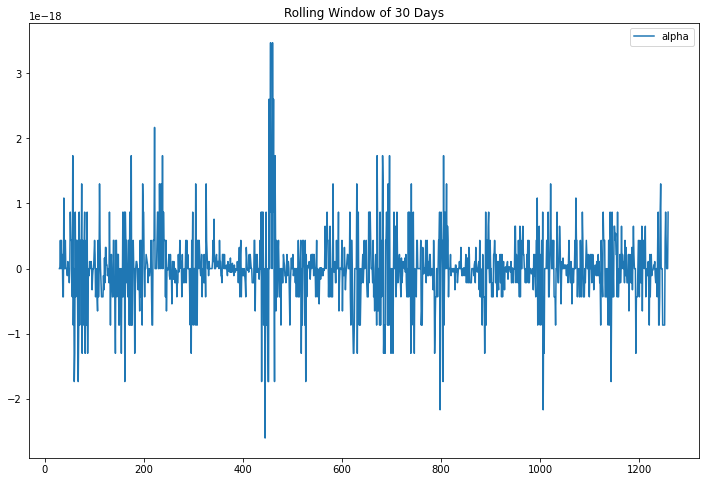

**************************************************************************************************** 




 **************************************** ['AVGO', 'CTSH'] ****************************************


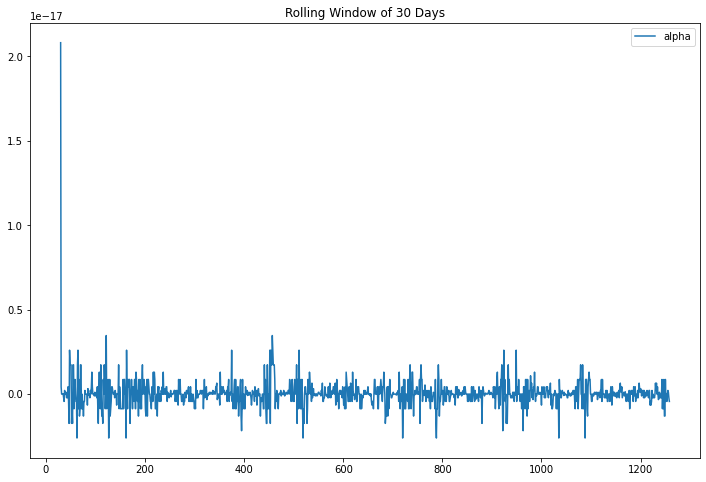

**************************************************************************************************** 




 **************************************** ['FFIV', 'STX'] ****************************************


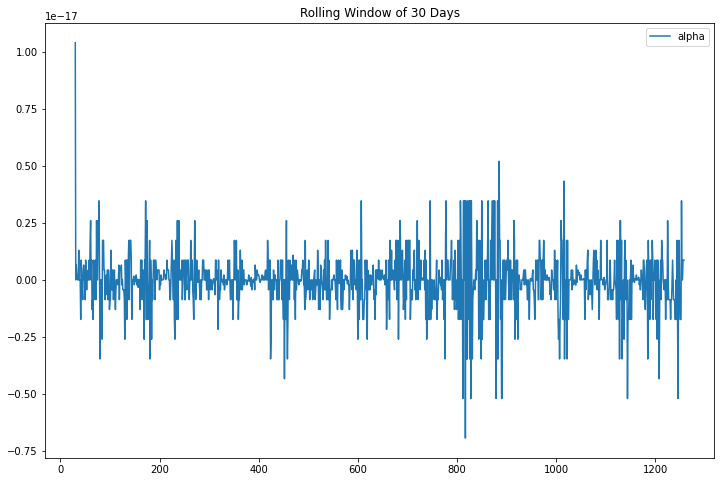

**************************************************************************************************** 




 **************************************** ['CVX', 'MRO'] ****************************************


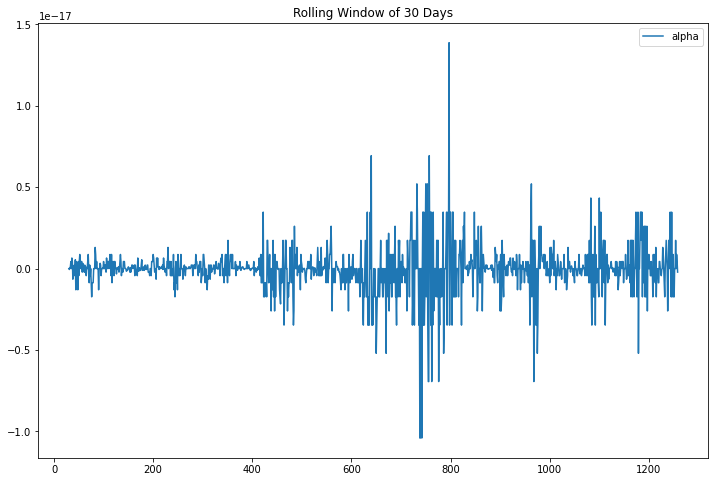

**************************************************************************************************** 




 **************************************** ['APA', 'OXY'] ****************************************


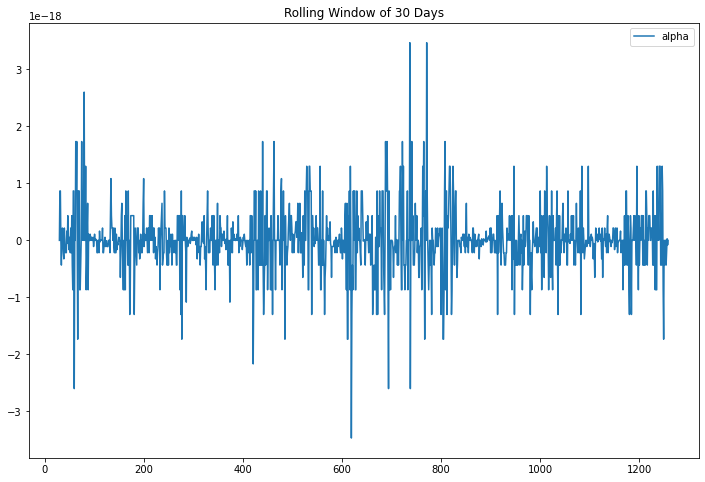

**************************************************************************************************** 




 **************************************** ['HES', 'OKE'] ****************************************


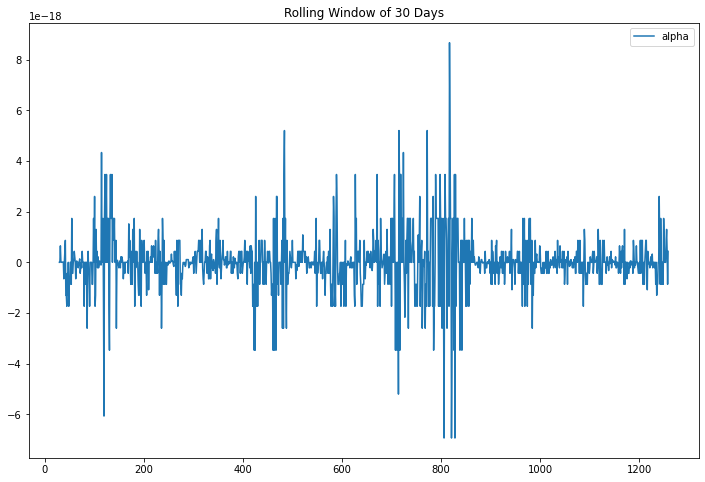

**************************************************************************************************** 




 **************************************** ['ARE', 'EQR'] ****************************************


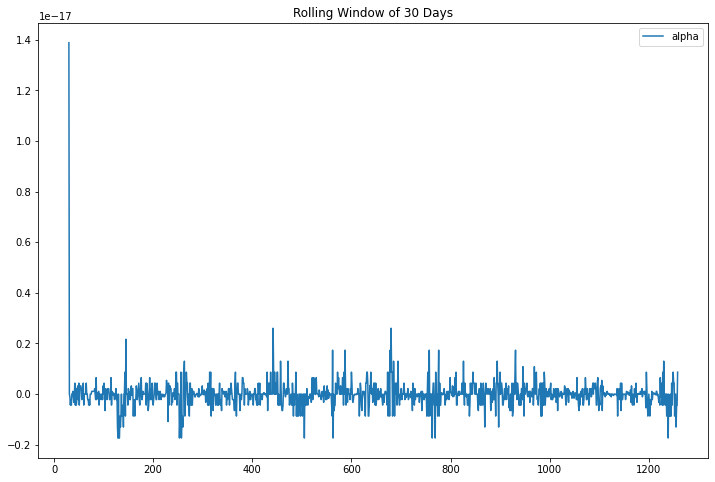

**************************************************************************************************** 




 **************************************** ['CCI', 'ESS'] ****************************************


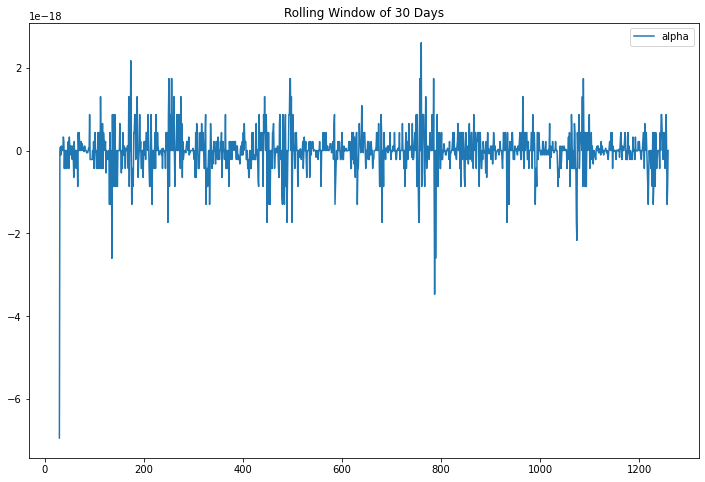

**************************************************************************************************** 




 **************************************** ['CCI', 'FRT'] ****************************************


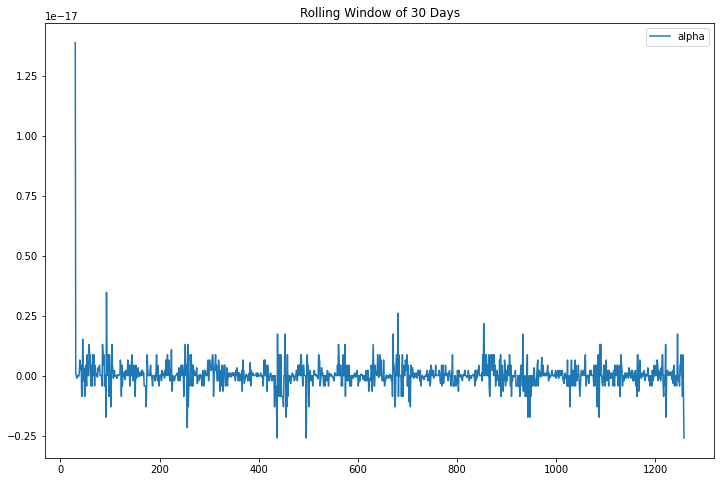

**************************************************************************************************** 




In [70]:
## Rolloing regression

import pandas as pd
import numpy as np
# import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline 

def market_beta(X,Y,N):
    """ 
    X = The independent variable which is the Market
    Y = The dependent variable which is the Stock
    N = The length of the Window
     
    It returns the alphas and the betas of
    the rolling regression
    """
    # all the observations
    obs = len(X)
     
    # initiate the betas with null values
    betas = np.full(obs, np.nan)
     
    # initiate the alphas with null values
    alphas = np.full(obs, np.nan)
     
     
    for i in range((obs-N)):
        regressor = LinearRegression()
        regressor.fit(X.to_numpy()[i : i + N+1].reshape(-1,1), Y.to_numpy()[i : i + N+1])
         
        betas[i+N]  = regressor.coef_[0]
        alphas[i+N]  = regressor.intercept_
 
    return(alphas, betas)

# top_pairs_corBrandPairs = [['IEX', 'LEN'],['DRE', 'SWKS'],['LEN', 'LOW']]
# top_pair_coBrand = [['NFLX','AMZN'],['AMZN','CRM'],['QCOM','TSM']]
secWise_pairs
sector_stock_data_RR = pd.read_csv("/content/sector_stock_data_RR.csv")
for pair in secWise_pairs:
  print("\n\n","*"*40,pair,"*"*40)
  temp = sector_stock_data_RR[sector_stock_data_RR["Name"] == pair[0]]
  pair_1_returns = sector_stock_data_RR[sector_stock_data_RR["Name"] == pair[0]]["returns"]
  pair_1_returns = sector_stock_data_RR[sector_stock_data_RR["Name"] == pair[1]]["returns"]
  results = market_beta(pair_1_returns, pair_1_returns, 30)
  results = pd.DataFrame(list(zip(*results)), columns = ['alpha', 'beta'])

  temp.set_index('date')
  plt.figure(figsize=(12,8))
  results.alpha.plot.line(x=temp["date"])
  plt.title("Rolling Window of 30 Days")
  plt.legend()
  plt.show()
  print("*"*100,"\n\n")

-------------------------------------------------- ['IEX', 'LEN'] -------------------------------------------------- 




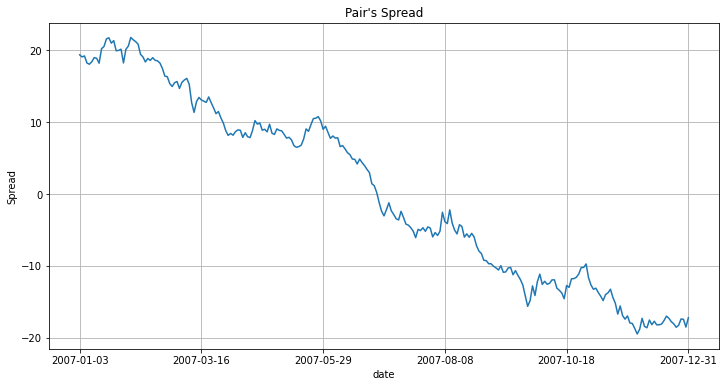

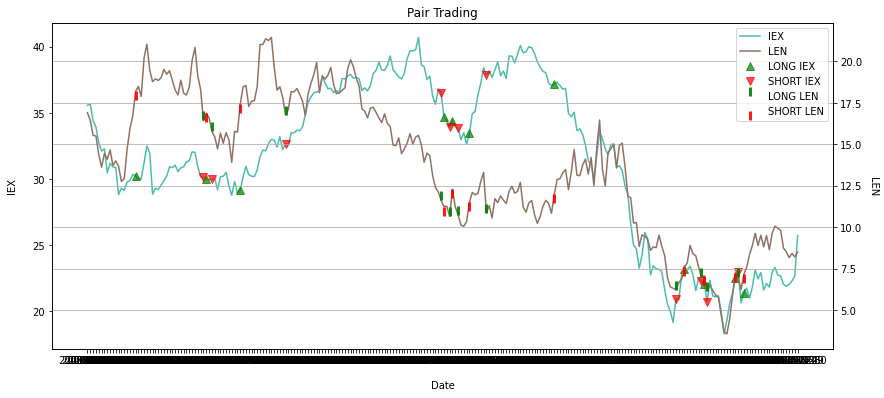

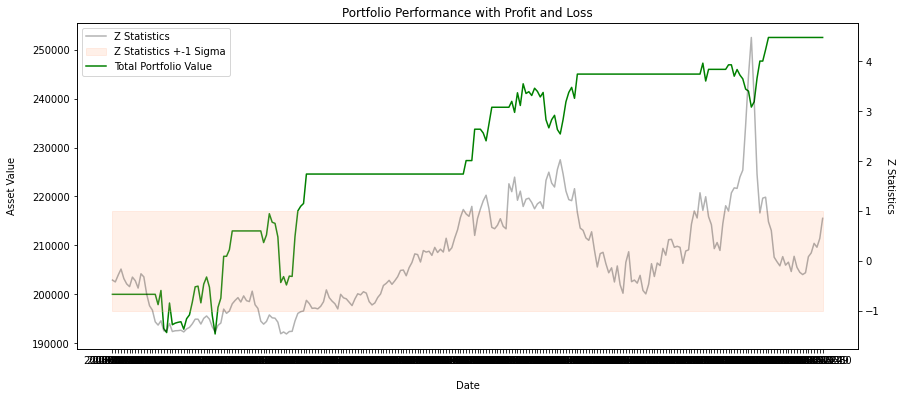

------------------------------------------------------------------------------------------------------------------------------------------------------ 


-------------------------------------------------- ['DRE', 'SWKS'] -------------------------------------------------- 




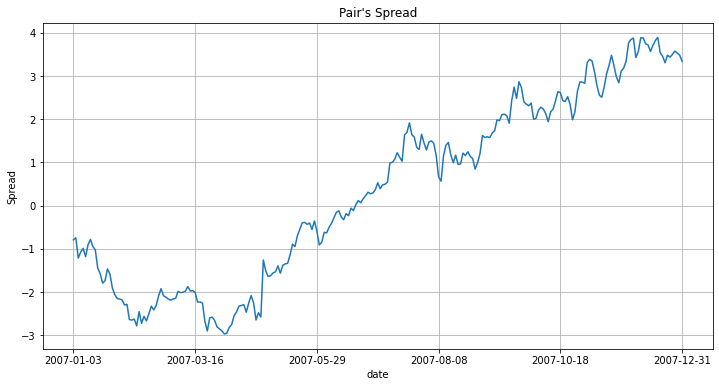

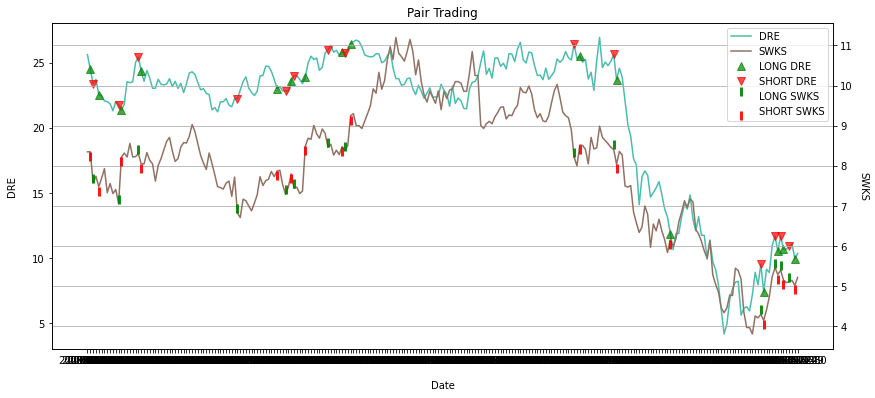

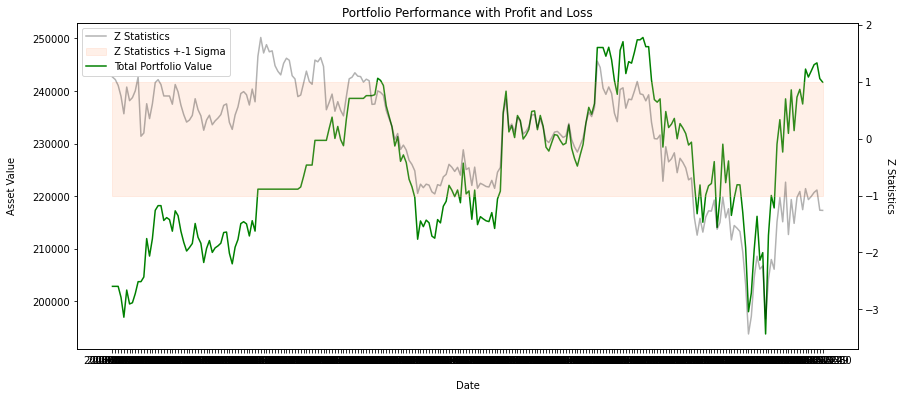

------------------------------------------------------------------------------------------------------------------------------------------------------ 


-------------------------------------------------- ['LEN', 'LOW'] -------------------------------------------------- 




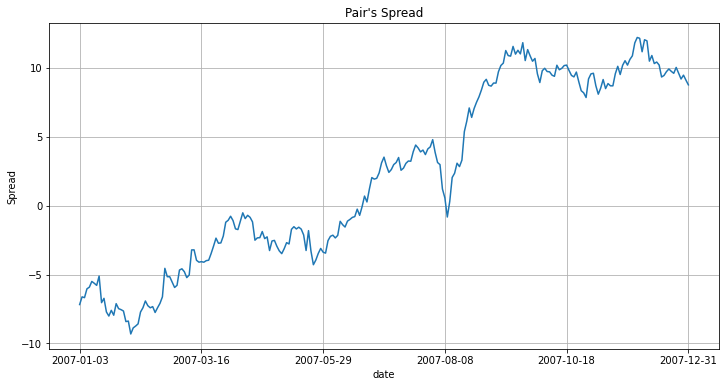

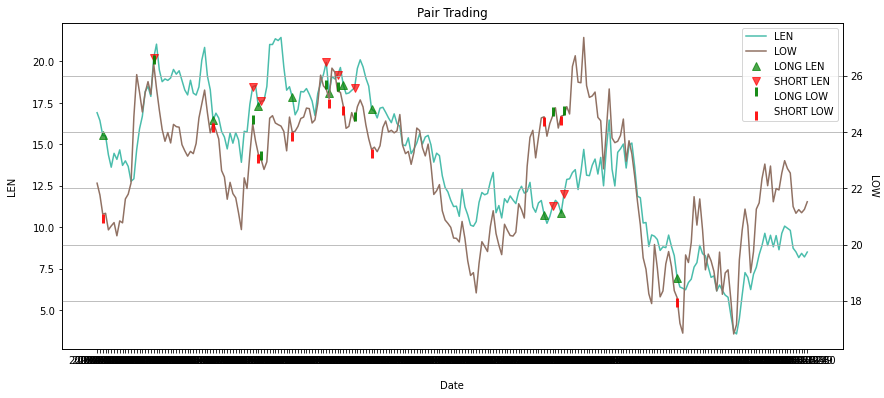

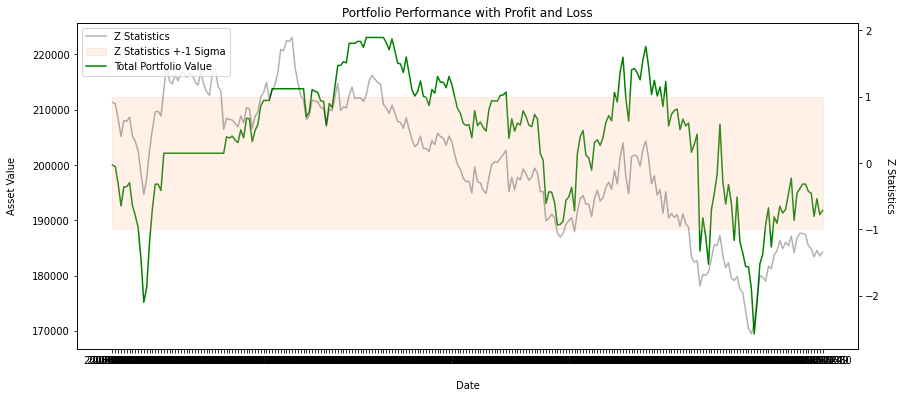

------------------------------------------------------------------------------------------------------------------------------------------------------ 




In [76]:
## Analysis pairs during financial crisis
def main_fin(stocks):
  close = stocks.unstack(['Name'])['close'].sort_index()
  close = close.dropna()
  close.head(2)

  # train test split 
  train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)

  # quick view of head and tail of train set
  train_close.head(2).append(train_close.tail(2))

  # global top_pairs_corrCointPair 
  # top_pairs_corrCointPair = {}
  top_pairs_corrCointPair = [['IEX', 'LEN'],['DRE', 'SWKS'],['LEN', 'LOW']]
  for pair in top_pairs_corrCointPair:
    print("-"*50,pair,"-"*50,"\n\n")
    pair_test(pair,train_close)
    trading_signals(pair,test_close)
    print("-"*150,"\n\n")

yf_data_2006_2009 = pd.read_csv("/content/yahoo_data_2007_2008.csv")
main_fin(yf_data_2006_2009.set_index(['Name','date']))

In [ ]:
# calculating the returns
# sector_stock_data_RR['returns'] = sector_stock_data_RR['close'].pct_change()
# sector_stock_data_RR['log_return'] = np.log(sector_stock_data_RR['close']) - np.log(sector_stock_data_RR['close'].shift(1))
# sector_stock_data_RR.dropna(inplace=True)
# sector_stock_data_RR